# Fact Rank

In [1]:
import chromadb

from config import DATA_DIR

In [2]:
chroma_db_path = DATA_DIR.joinpath("chroma").resolve()

chroma = chromadb.PersistentClient(path=str(chroma_db_path))
vecstore = chroma.get_or_create_collection("factrank")

## Load Data

In [3]:
import json

from buff.openalex import Work
from buff.openalex.download import get_paper_text
from buff.llm.utils import get_token_count

In [4]:
with open("works.json", "r", encoding="utf-8") as file:
    FOCUS_PAPER = json.load(file).get("id") 
    
with open("citations.json", "r", encoding="utf-8") as file:
    CITATIONS = list(json.load(file).keys())
    
with open("references.json", "r", encoding="utf-8") as file:
    REFERENCES = list(json.load(file).keys())
    
print("Main paper:", FOCUS_PAPER)
print("Citations:", len(CITATIONS))
print("References:", len(REFERENCES))

Main paper: https://openalex.org/W2994792393
Citations: 39
References: 23


In [5]:
WORKS = {
    work_id: await Work(work_id).data
    for work_id in [FOCUS_PAPER] + CITATIONS + REFERENCES
}
print("Works:", len(WORKS))

Works: 63


In [6]:
TEXTS = {
    work_id: await get_paper_text(work)
    for work_id, work in WORKS.items()
}
print("Texts:", len(TEXTS))

Texts: 63


## Process and Prepare

In [7]:
# from buff.llm.split import split_text
# 
# TEXT_CHUNKS = {
#     work_id: split_text(text)
#     for work_id, text in TEXTS.items()
# }
# 
# # Save the chunks
# with open("chunks.json", "w", encoding="utf-8") as f:
#     json.dump(TEXT_CHUNKS, f, indent=2)

In [8]:
# Load the chunks
with open("chunks.json", "r", encoding="utf-8") as f:
    TEXT_CHUNKS = json.load(f)

In [9]:
print("Chunks:", sum(len(chunks) for chunks in TEXT_CHUNKS.values()))

Chunks: 2500


### Embed

In [10]:
# from buff.llm.embed import embed_texts
# 
# EMBEDDINGS = {
#     work_id: await embed_texts(chunks)
#     for work_id, chunks in TEXT_CHUNKS.items()
# }
# 
# # Save the embeddings
# with open("embeddings.json", "w", encoding="utf-8") as f:
#     json.dump(EMBEDDINGS, f, indent=2)

In [11]:
# Load the embeddings
with open("embeddings.json", "r", encoding="utf-8") as f:
    EMBEDDINGS = json.load(f)

In [12]:
print("Embeddings:", sum(len(embeds) for embeds in EMBEDDINGS.values()))

Embeddings: 2500


### Store

In [16]:
# from buff.llm.models import Document, DocumentMetadata
# 
# # Build the documents
# DOCUMENTS = {
#     work_id: [
#         Document(
#             metadata=DocumentMetadata(
#                 index=i,
#                 work_id=work_id,
#                 doi=str(WORKS[work_id].doi),
#                 text=TEXT_CHUNKS[work_id][i]
#             ),
#             id=f"{work_id}-{i}",
#             values=embed
#         )
#         for i, embed in enumerate(embeds)
#     ]
#     for work_id, embeds in EMBEDDINGS.items()
# }
# 
# # Create the following lists of data from the documents
# TEXT_CHUNK_IDS = [doc.id for docs in DOCUMENTS.values() for doc in docs]
# TEXT_CHUNK_EMBEDDINGS = [doc.values for docs in DOCUMENTS.values() for doc in docs]
# TEXT_CHUNK_METADATA = [doc.metadata.model_dump(mode="json") for docs in DOCUMENTS.values() for doc in docs]
# print(f"Total: {len(TEXT_CHUNK_IDS)} documents.")
# if not len(TEXT_CHUNK_EMBEDDINGS) == len(TEXT_CHUNK_METADATA) == len(TEXT_CHUNK_IDS):
#     raise ValueError("Invalid data")
# 
# # Store the embeddings
# vecstore.add(
#     ids=TEXT_CHUNK_IDS,
#     embeddings=TEXT_CHUNK_EMBEDDINGS,
#     metadatas=TEXT_CHUNK_METADATA
# )
# print("Embeddings stored")

Total: 2500 documents.
Embeddings stored


In [ ]:
# Query the chroma db to check the number of stored embeddings
print("Stored embeddings:", vecstore.count())

### Stats

In [17]:
# Print the min-median-max number of chunks per work
print("Chunks per work:", min(len(chunks) for chunks in TEXT_CHUNKS.values()), "-", sum(len(chunks) for chunks in TEXT_CHUNKS.values()) / len(TEXT_CHUNKS), "-", max(len(chunks) for chunks in TEXT_CHUNKS.values()))

# Print the min-median-max number of tokens per chunk
print("Tokens per chunk:", min(get_token_count(chunk) for chunks in TEXT_CHUNKS.values() for chunk in chunks), "-", sum(get_token_count(chunk) for chunks in TEXT_CHUNKS.values() for chunk in chunks) / sum(len(chunks) for chunks in TEXT_CHUNKS.values()), "-", max(get_token_count(chunk) for chunks in TEXT_CHUNKS.values() for chunk in chunks))

Chunks per work: 11 - 39.682539682539684 - 81
Tokens per chunk: 25 - 526.578 - 929


## Similarity Search

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
SIM_MIN_THRESHOLD = 0.75
SIM_MAX_THRESHOLD = 1

DIS_MIN_THRESHOLD = -1
DIS_MAX_THRESHOLD = -0.75

In [21]:
def combine_close_chunks(
        indices: list[int],
        max_gap: int = 2
) -> list[tuple[int, int]]:
    """
    Combine close chunks based on a maximum allowed gap.
    
    :param indices: List of indices to combine.
    :param max_gap: Maximum allowed gap between consecutive indices to be considered close.
    :return: List of tuples, each containing a group of close indices.
    """
    if not indices:
        return []

    # Sort the indices and remove duplicates
    sorted_indices = sorted(set(indices))
    combined = [sorted_indices[0]]
    result = []

    for i in range(1, len(sorted_indices)):
        if sorted_indices[i] - combined[-1] <= max_gap:
            # Fill in missing indices between the current and the last index
            combined.extend(range(combined[-1] + 1, sorted_indices[i]))
            combined.append(sorted_indices[i])
        else:
            result.append(tuple(combined))
            combined = [sorted_indices[i]]

    result.append(tuple(combined))

    return result

In [22]:
def search_similar_chunks(
        work_1: str,
        work_2: str,
        min_t: float = SIM_MIN_THRESHOLD,
        max_t: float = SIM_MAX_THRESHOLD
) -> tuple[list[tuple[int, int]], list[tuple[int, int]]]:
    """
    Search for similar chunks between two works.
    
    :param work_1: First work ID.
    :param work_2: Second work ID.
    :param min_t: Minimum similarity threshold.
    :param max_t: Maximum similarity threshold.
    :return: List of tuples, each containing a group of close indices.
    """
    # Get the embeddings for the two works
    embeddings_1 = EMBEDDINGS[work_1]
    embeddings_2 = EMBEDDINGS[work_2]

    # Convert the lists to numpy arrays
    vecs_1 = np.array(embeddings_1)
    vecs_2 = np.array(embeddings_2)
    
    # Calculate the cosine similarity matrix
    sim_matrix = cosine_similarity(vecs_1, vecs_2)
    
    # Get the indices of the similar chunks based on the threshold
    similar_indices = np.argwhere((sim_matrix >= min_t) & (sim_matrix <= max_t)).tolist()
    
    # Split, sort and remove duplicates
    work_1_indices = list(sorted(set([index[0] for index in similar_indices])))
    work_2_indices = list(sorted(set([index[1] for index in similar_indices])))
    
    # Combine the indices
    work_1_combined = combine_close_chunks(work_1_indices)
    work_2_combined = combine_close_chunks(work_2_indices)
    
    return work_1_combined, work_2_combined

In [26]:
def plot_similarity_heatmap(work_1: str, work_2: str):
    """
    Plot a heatmap of the cosine similarity matrix between two works.
    
    :param work_1: ID of the first work.
    :param work_2: ID of the second work.
    """
    # Get the embeddings for the source and target works
    source_embeddings = EMBEDDINGS[work_1]
    target_embeddings = EMBEDDINGS[work_2]

    # Convert the lists to numpy arrays
    source_vectors = np.array(source_embeddings)
    target_vectors = np.array(target_embeddings)

    # Calculate the cosine similarity matrix
    similarity_matrix = cosine_similarity(source_vectors, target_vectors)

    # Create a custom colormap
    cmap = sns.diverging_palette(h_neg=10, h_pos=130, s=80, l=55, as_cmap=True)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, cmap=cmap, vmin=0, vmax=1, center=0.5,
                xticklabels=False, yticklabels=False, square=True, cbar_kws={"shrink": 0.8})

    plt.title(f"Cosine Similarity Heatmap: {work_1} vs {work_2}")
    plt.xlabel("Target Work Chunks")
    plt.ylabel("Source Work Chunks")
    plt.tight_layout()
    plt.show()

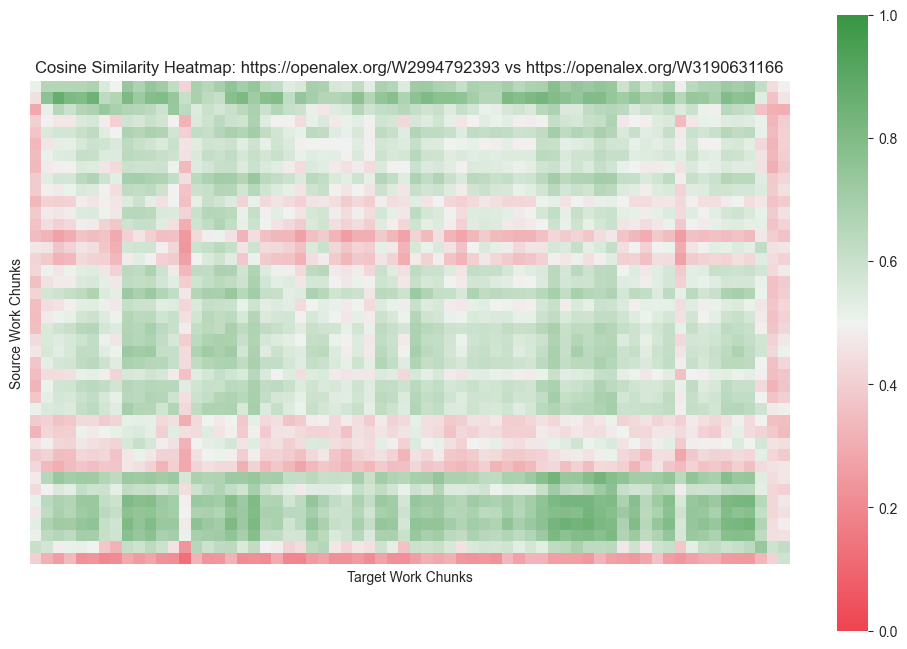

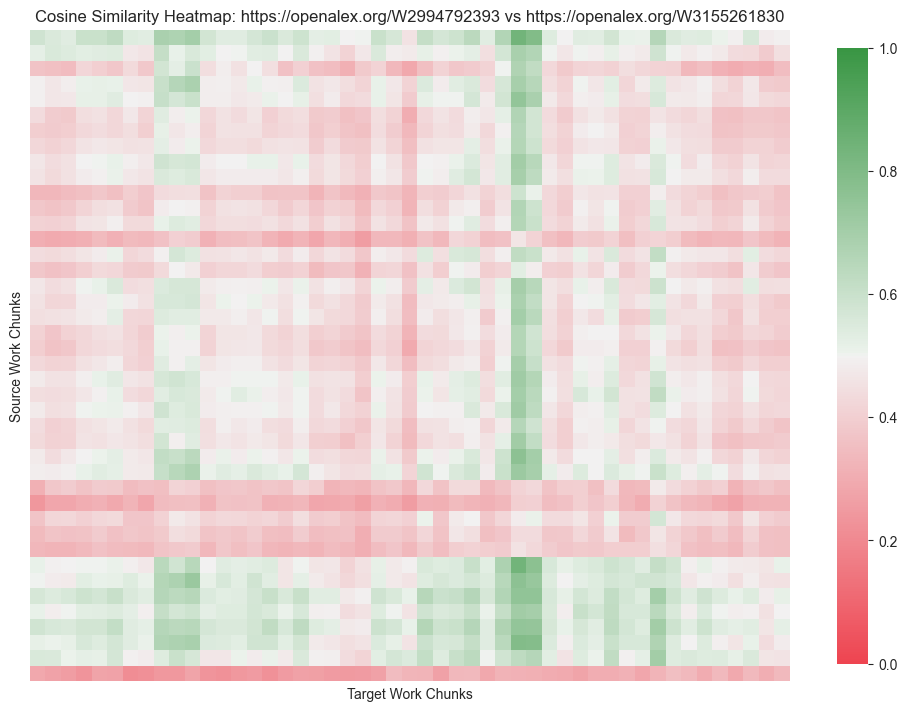

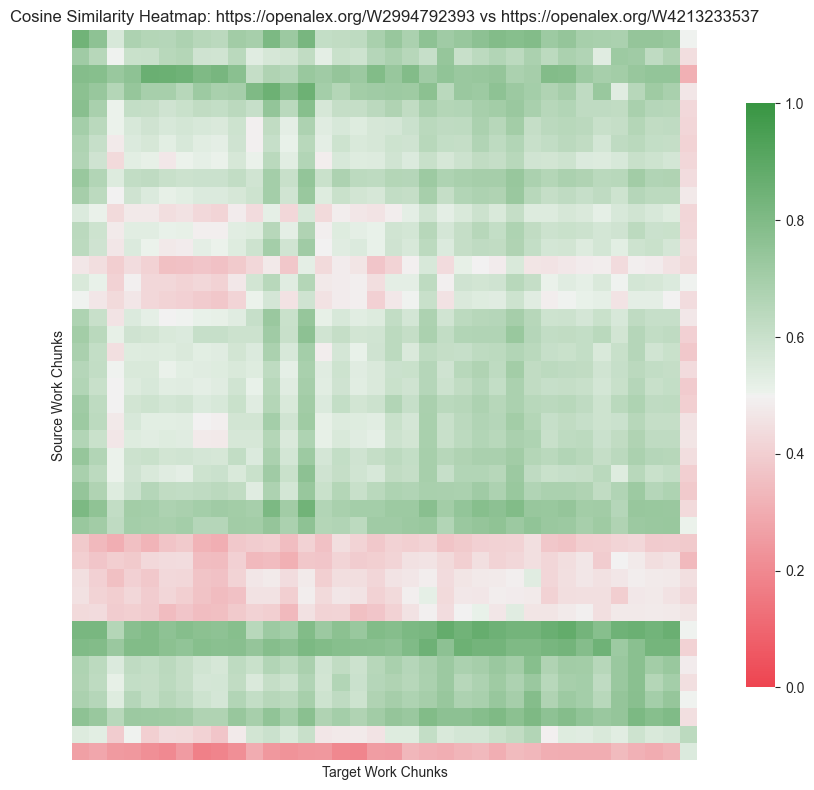

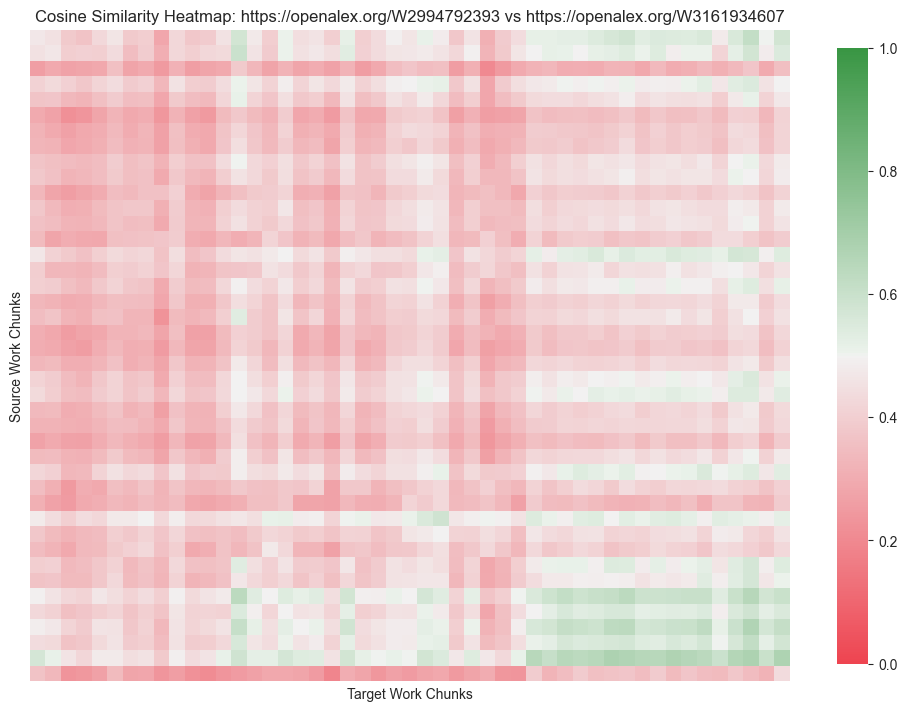

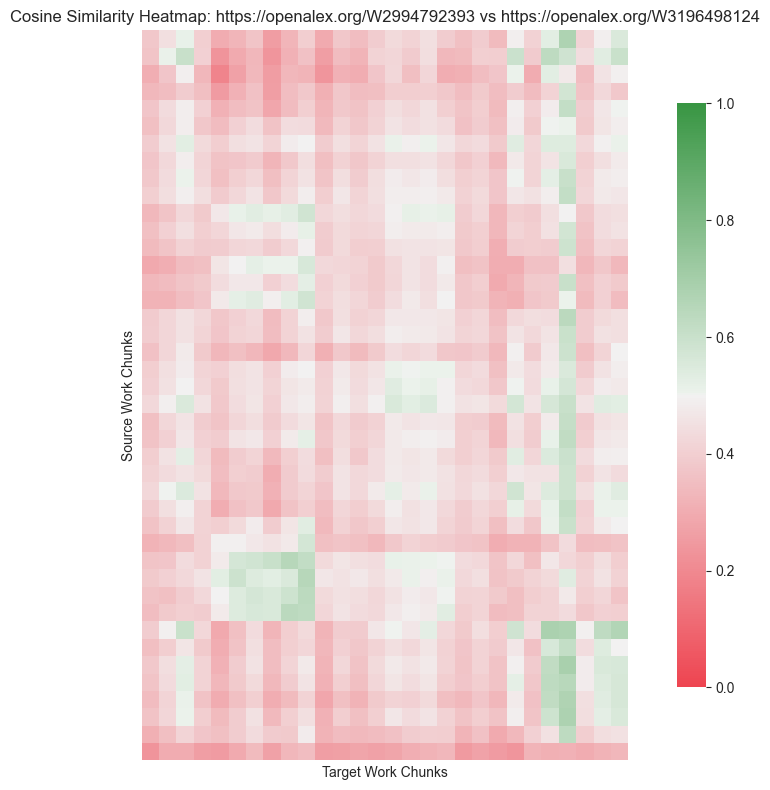

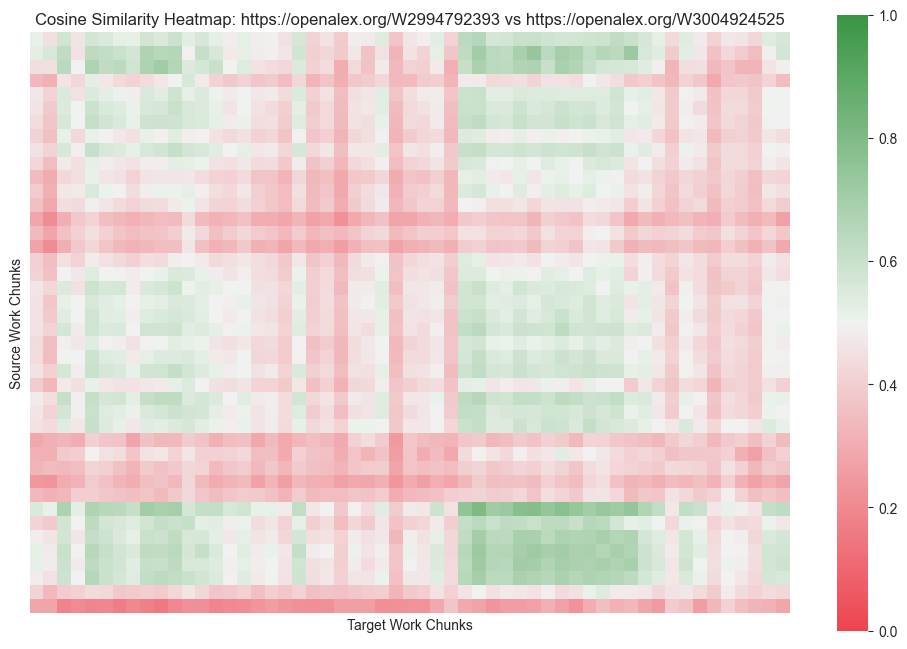

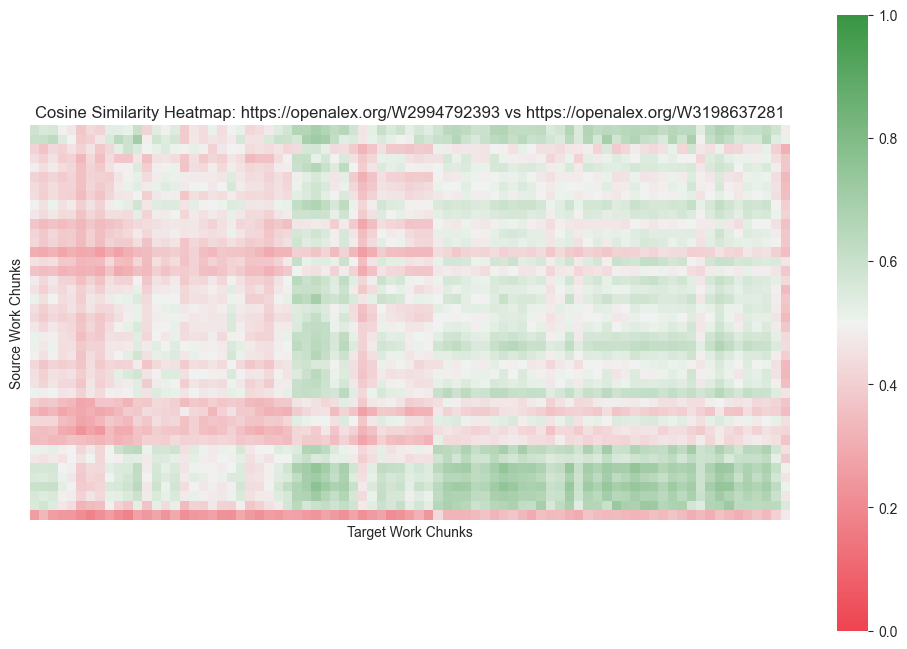

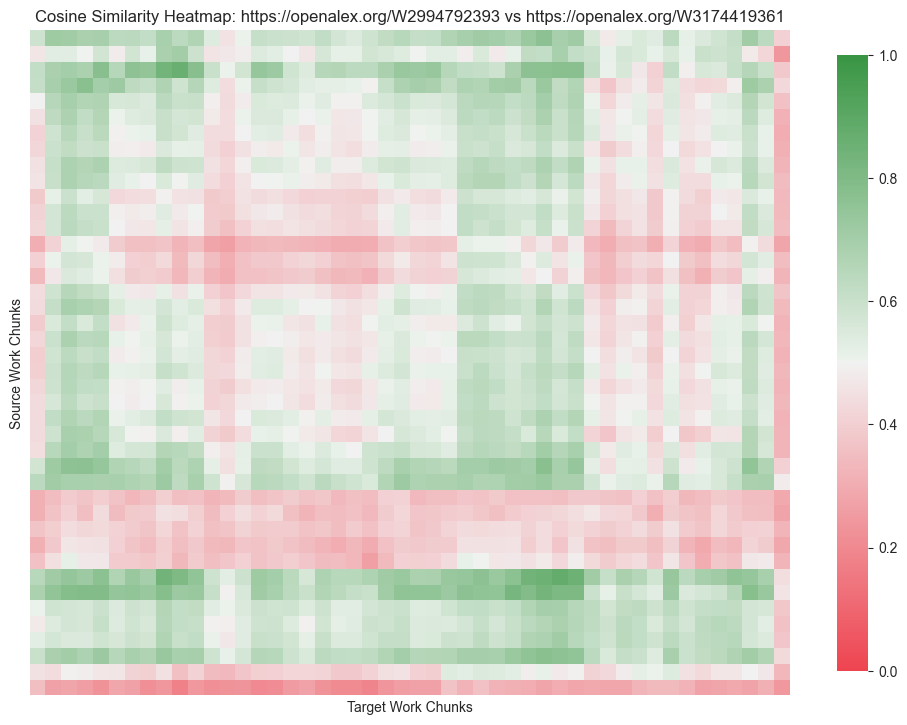

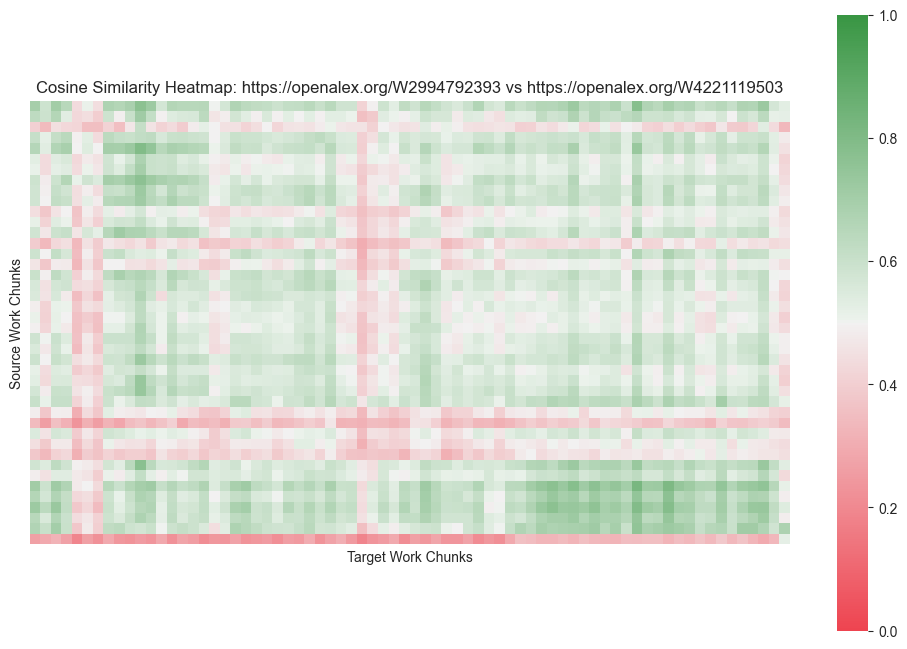

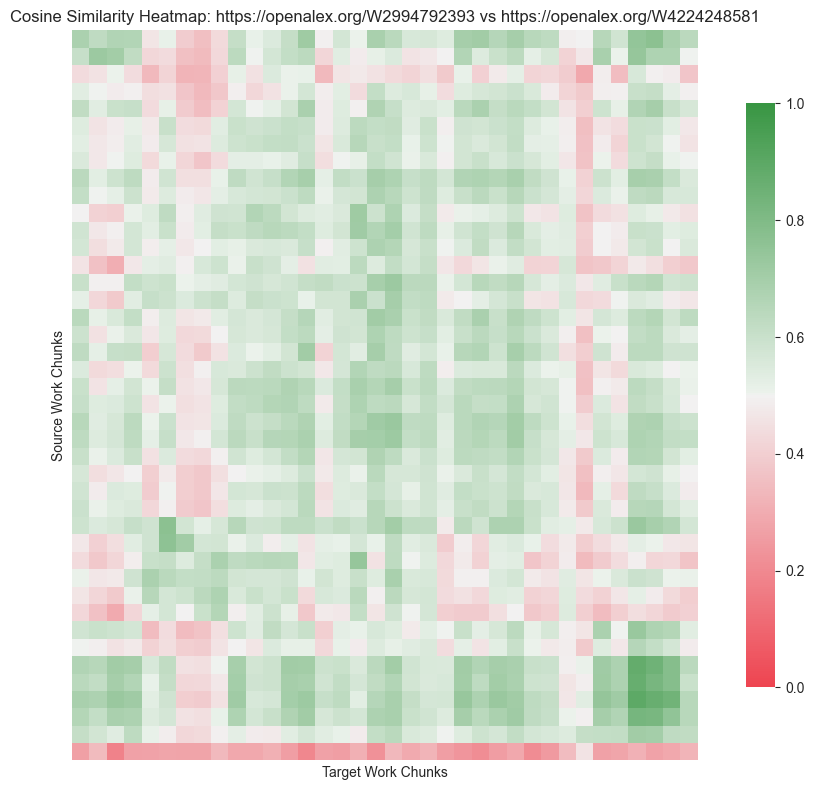

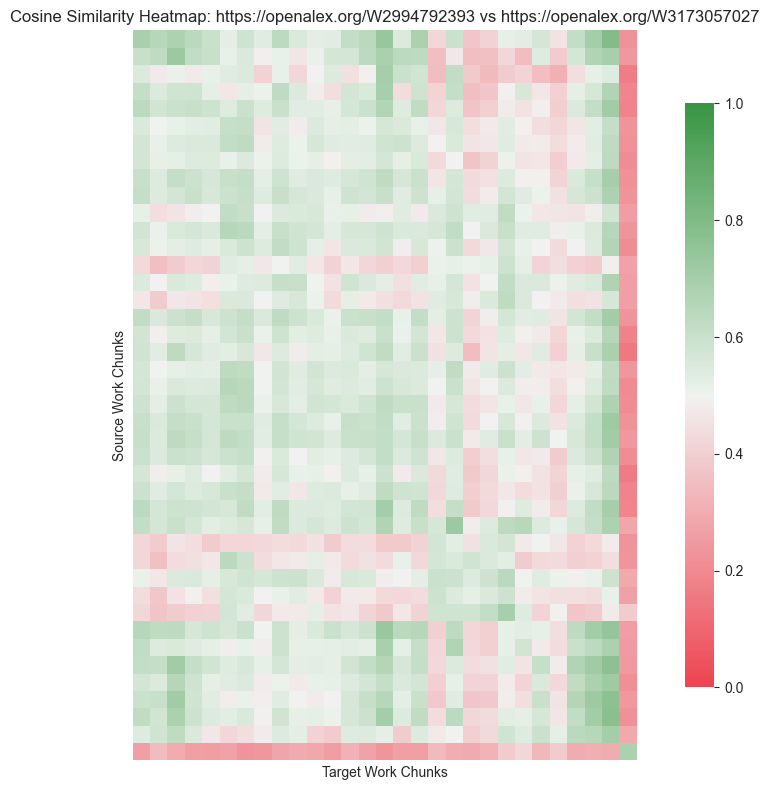

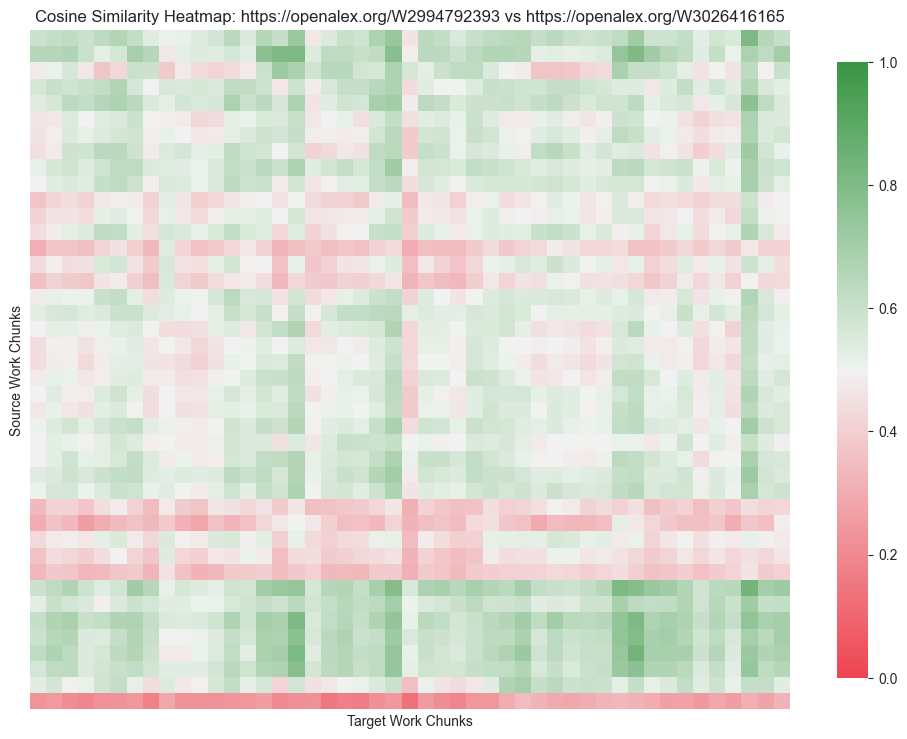

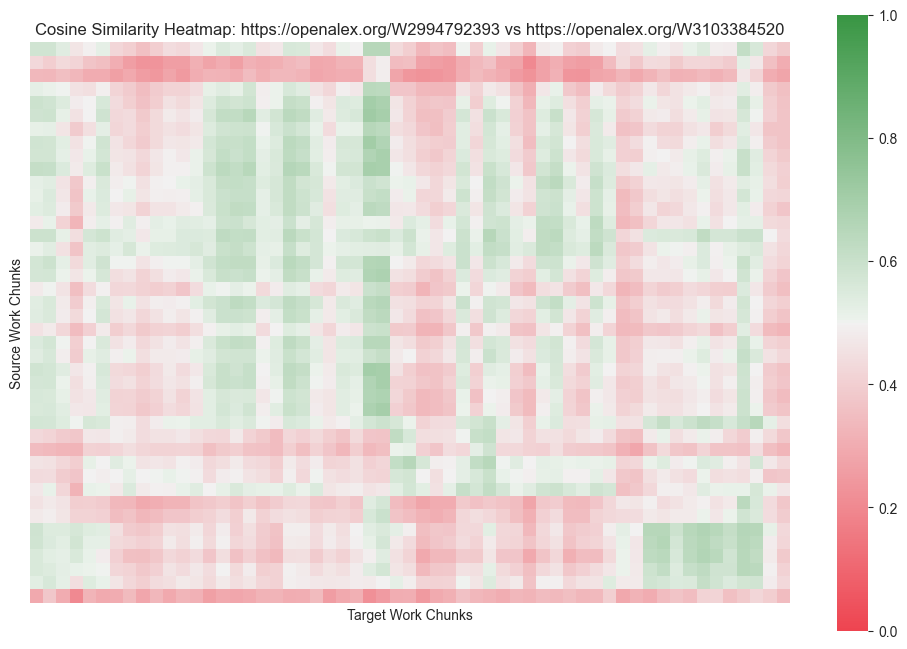

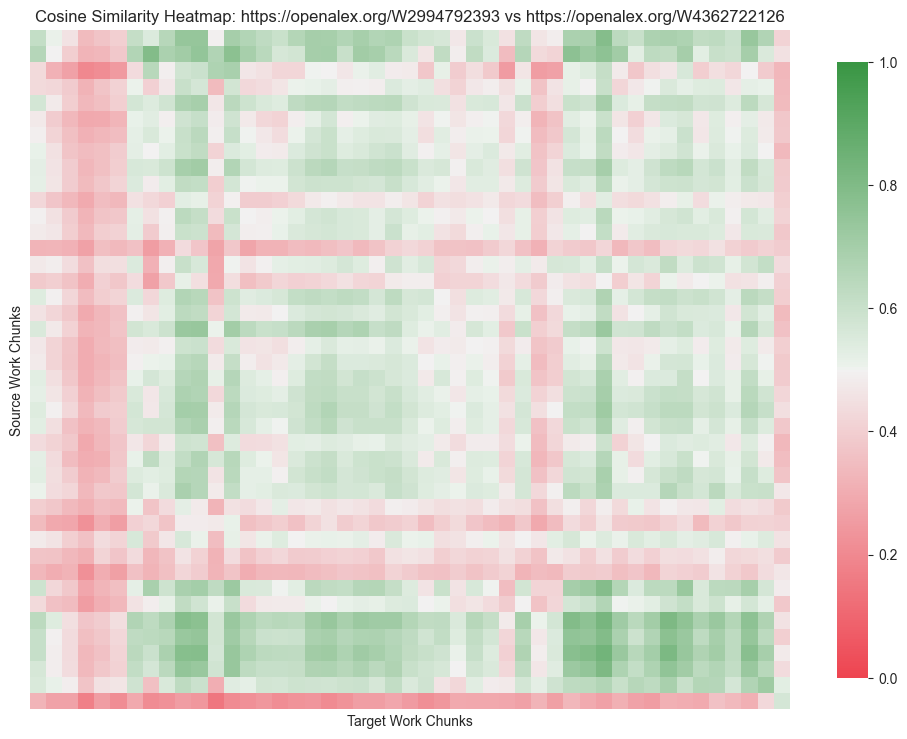

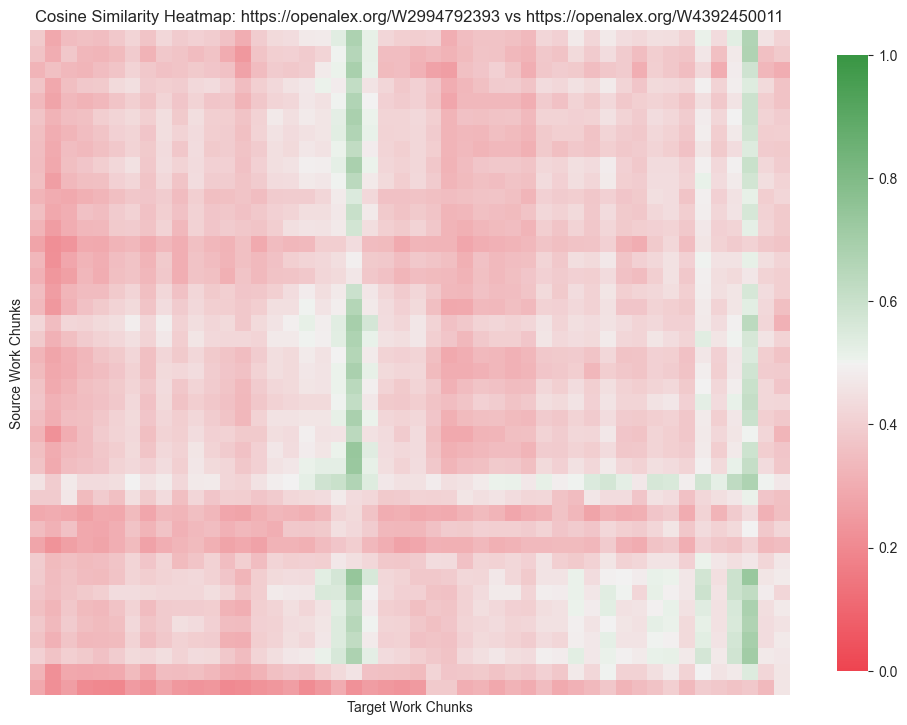

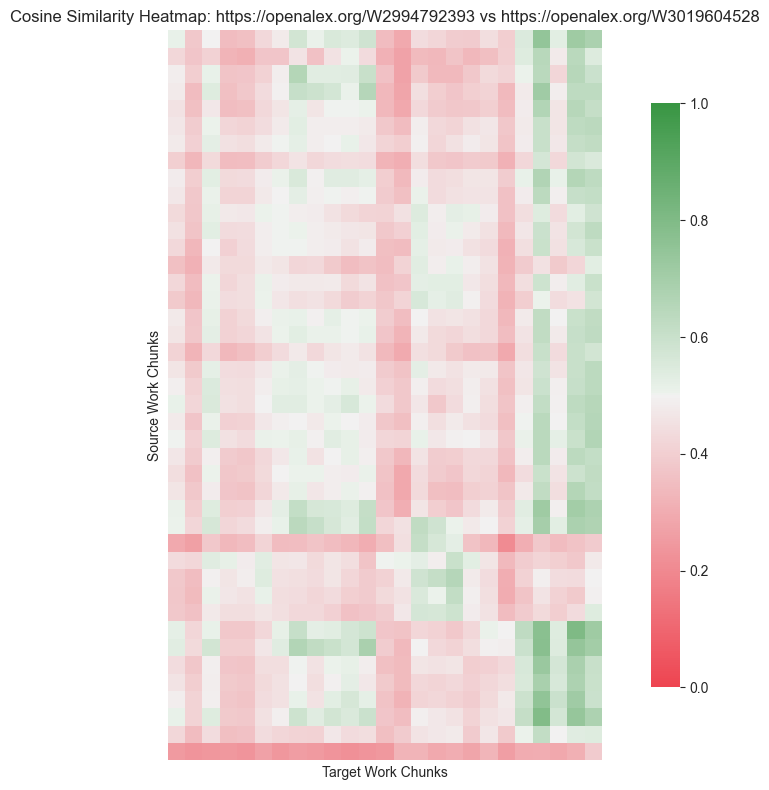

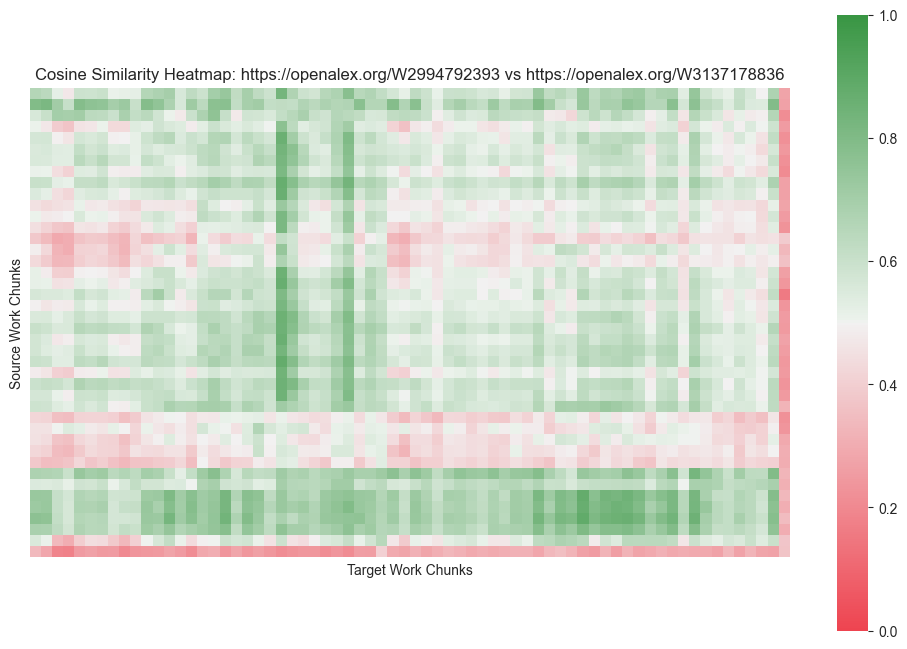

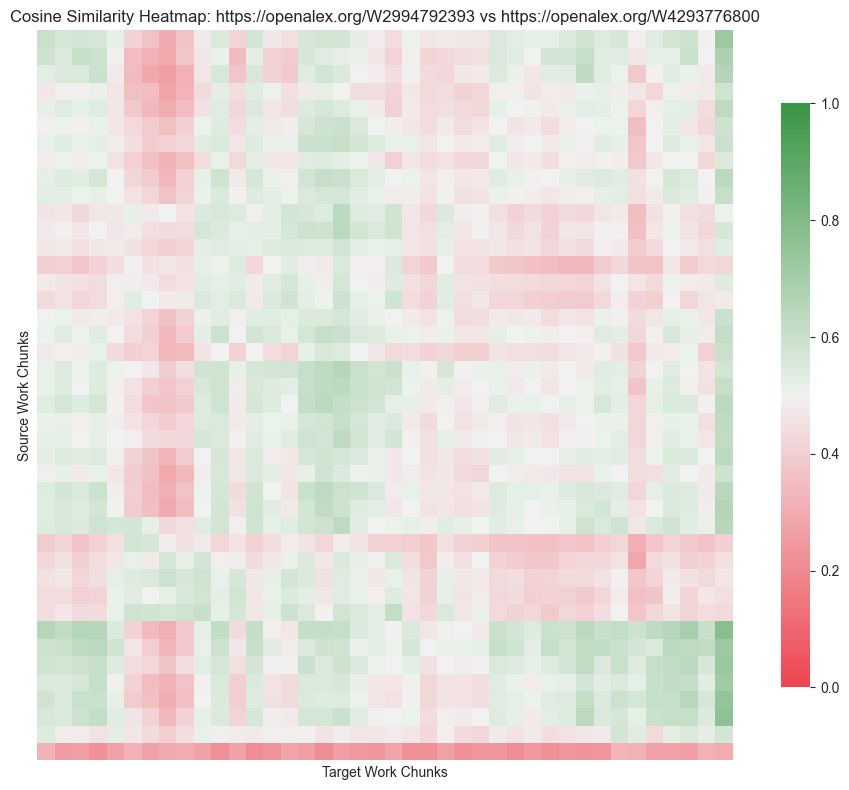

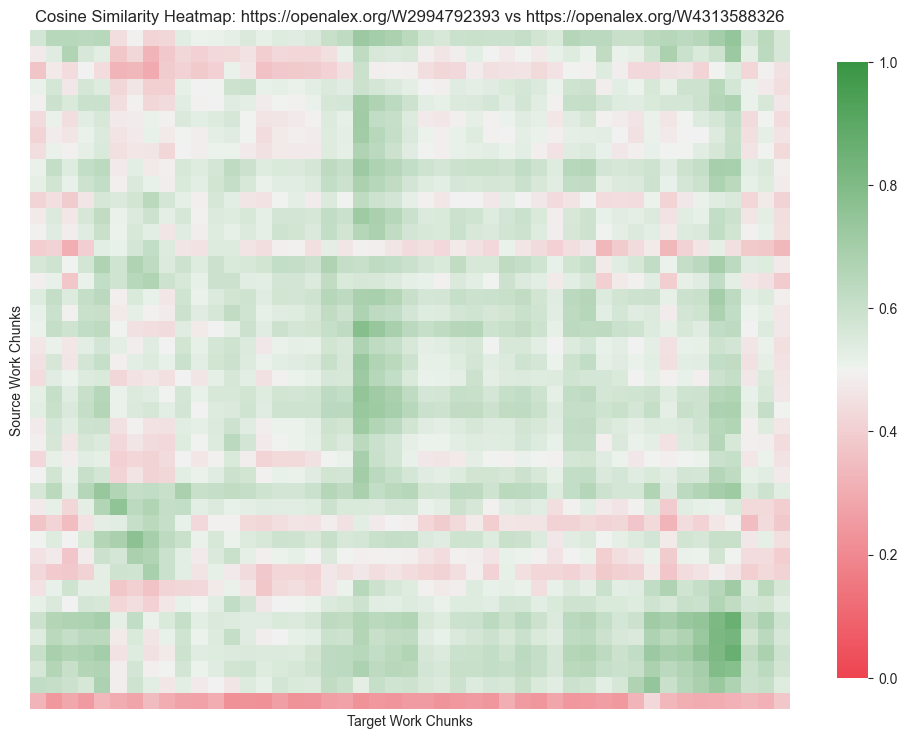

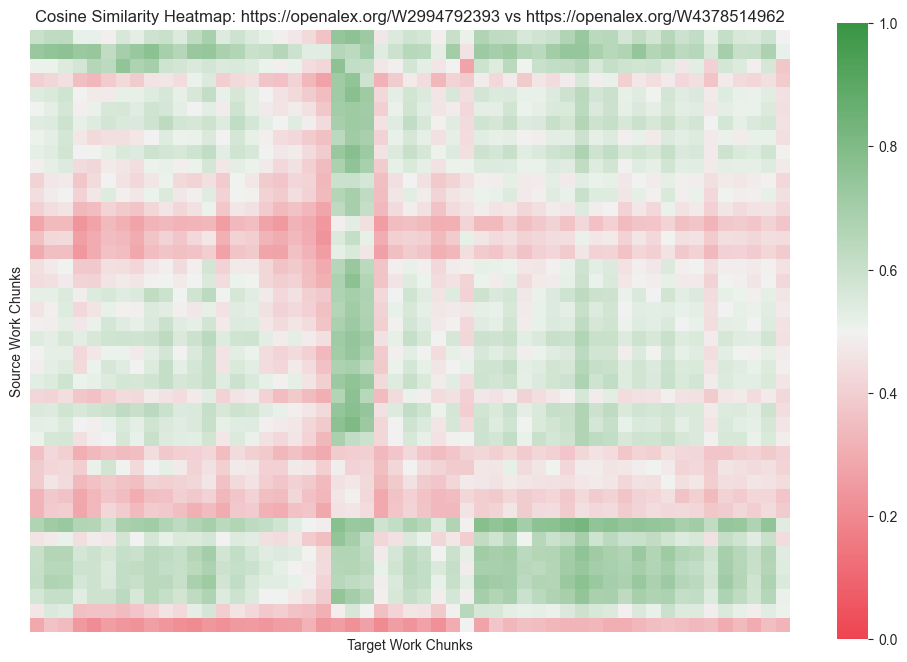

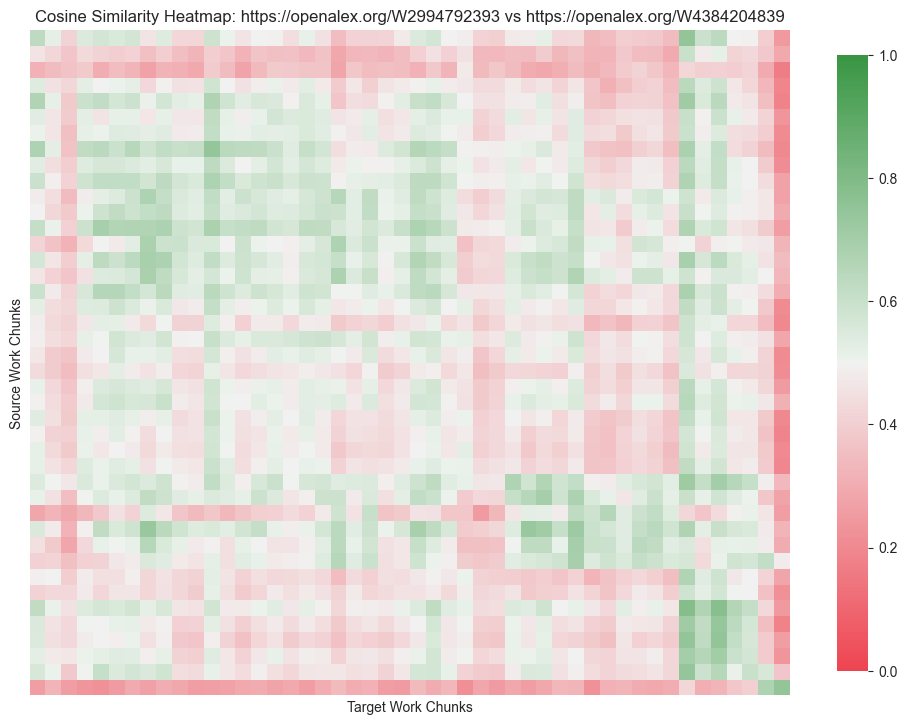

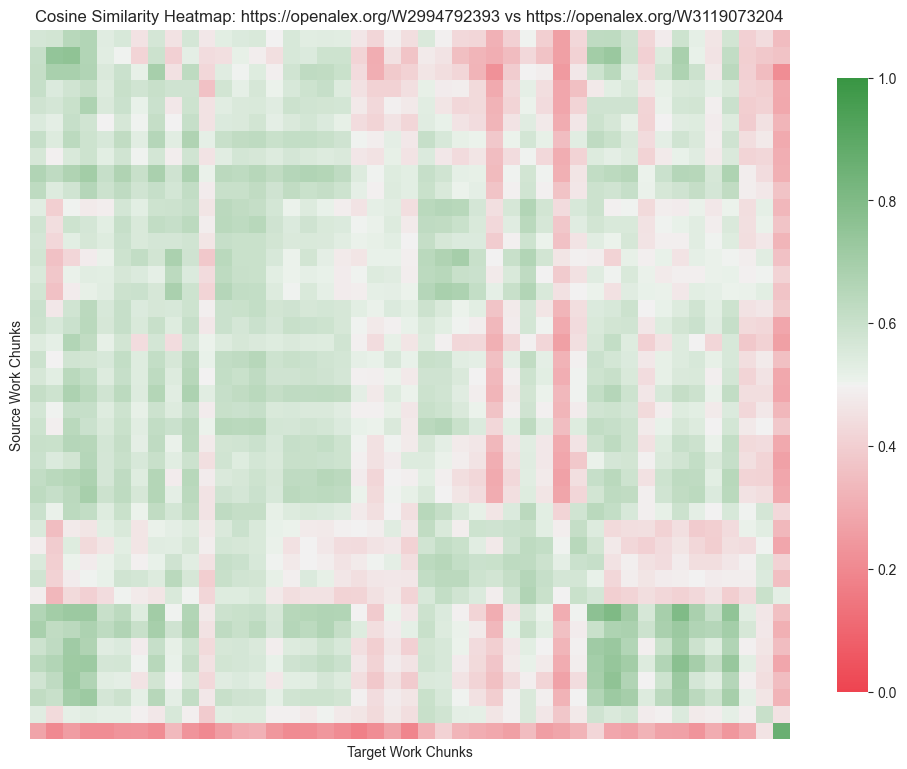

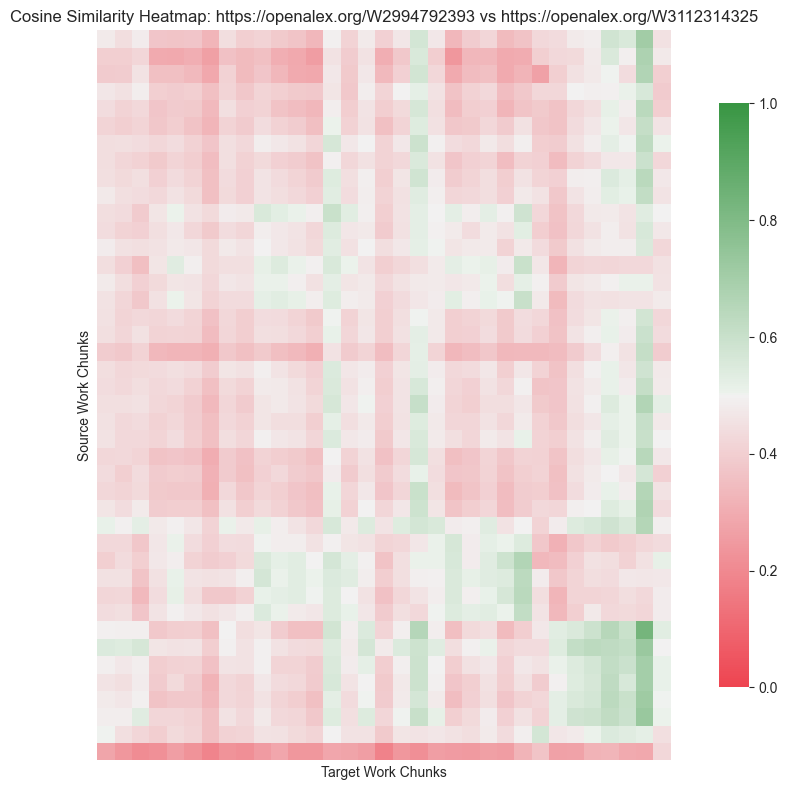

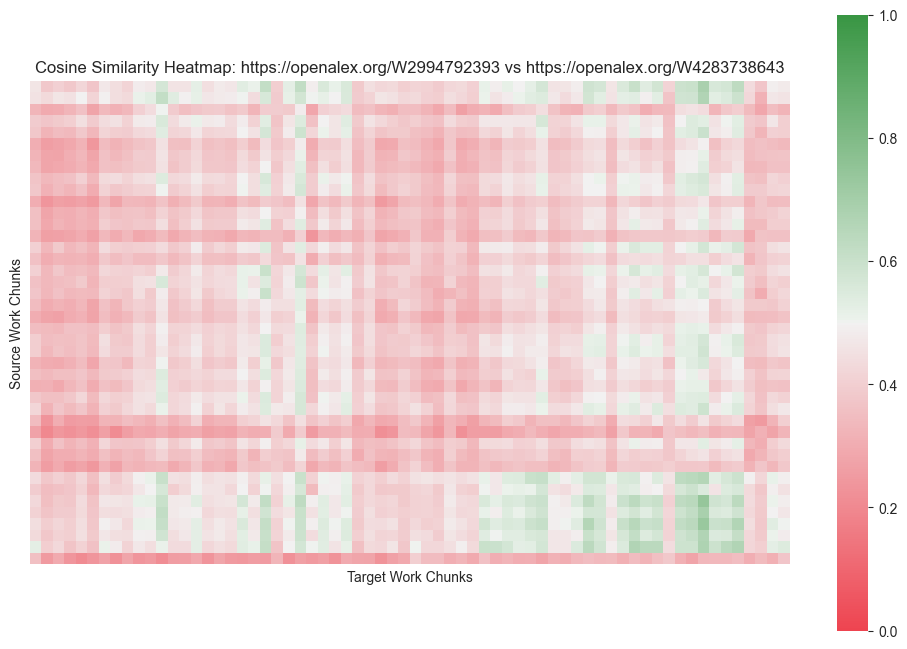

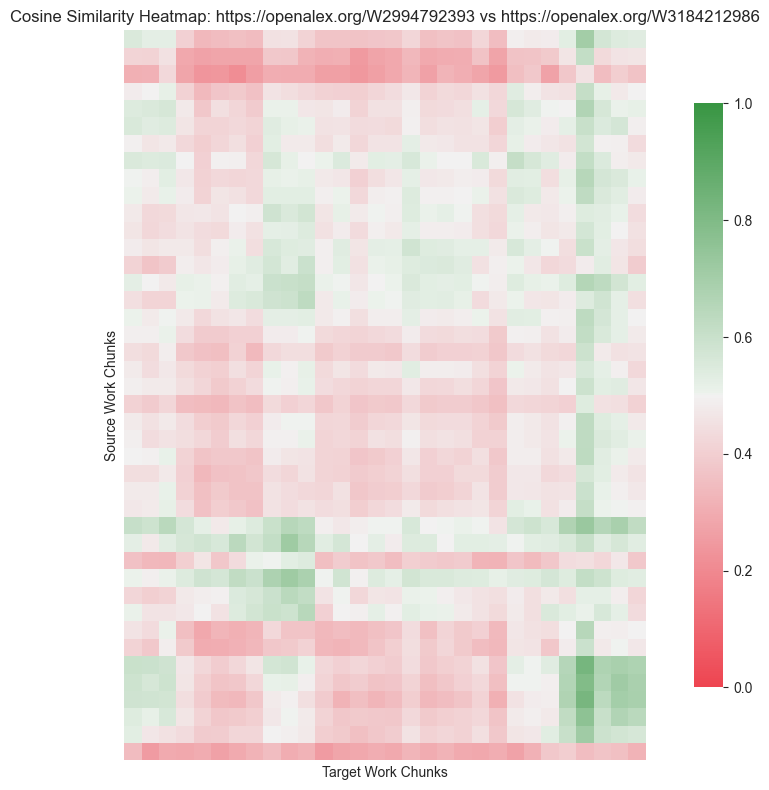

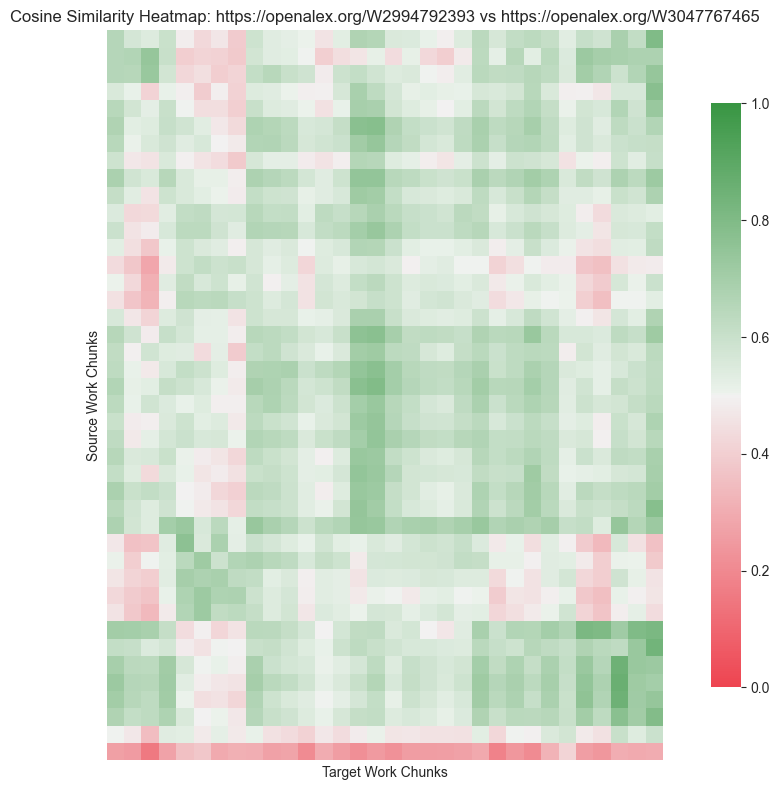

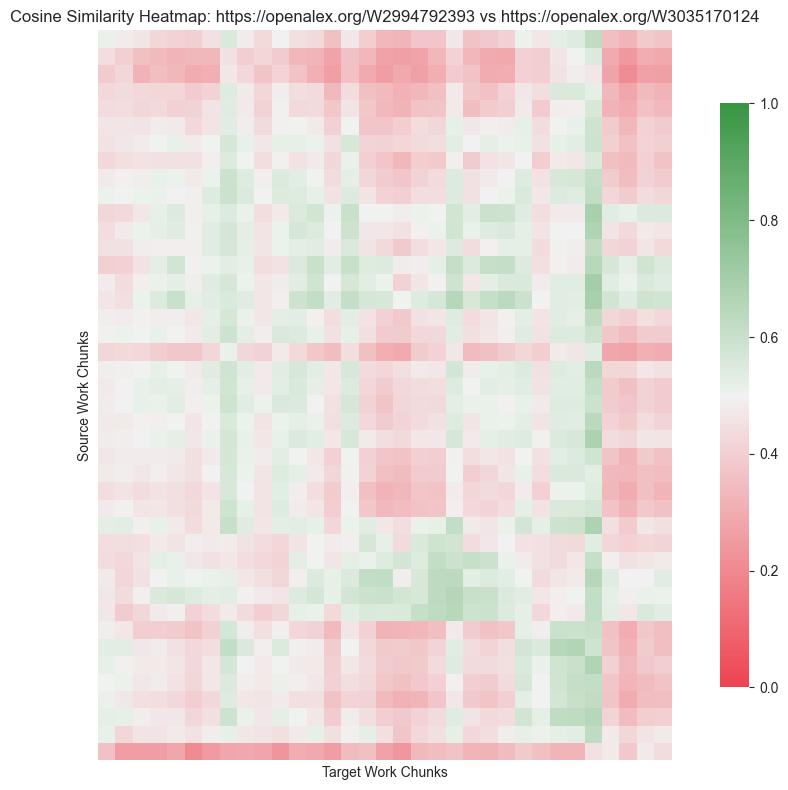

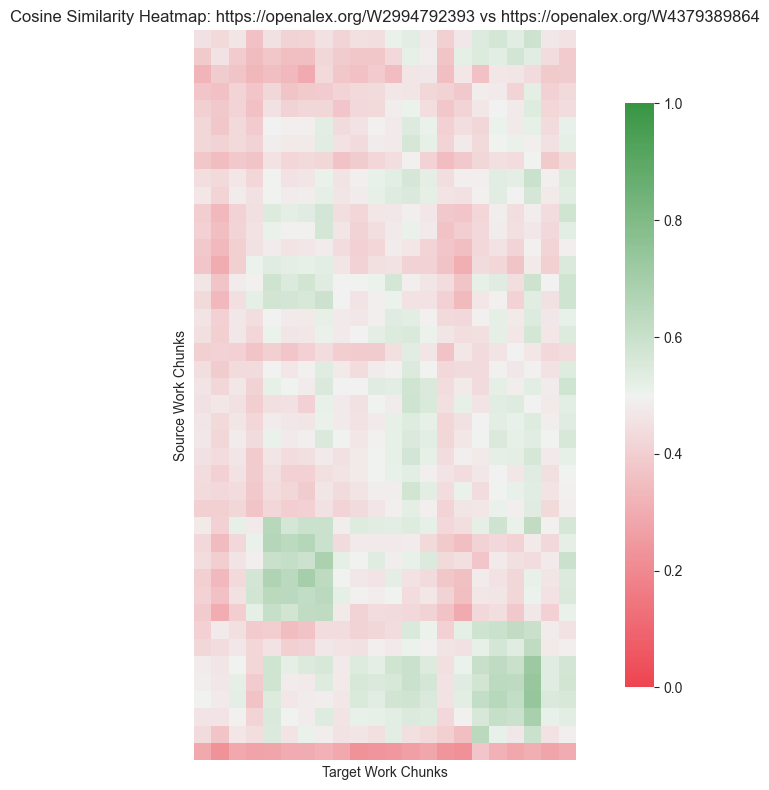

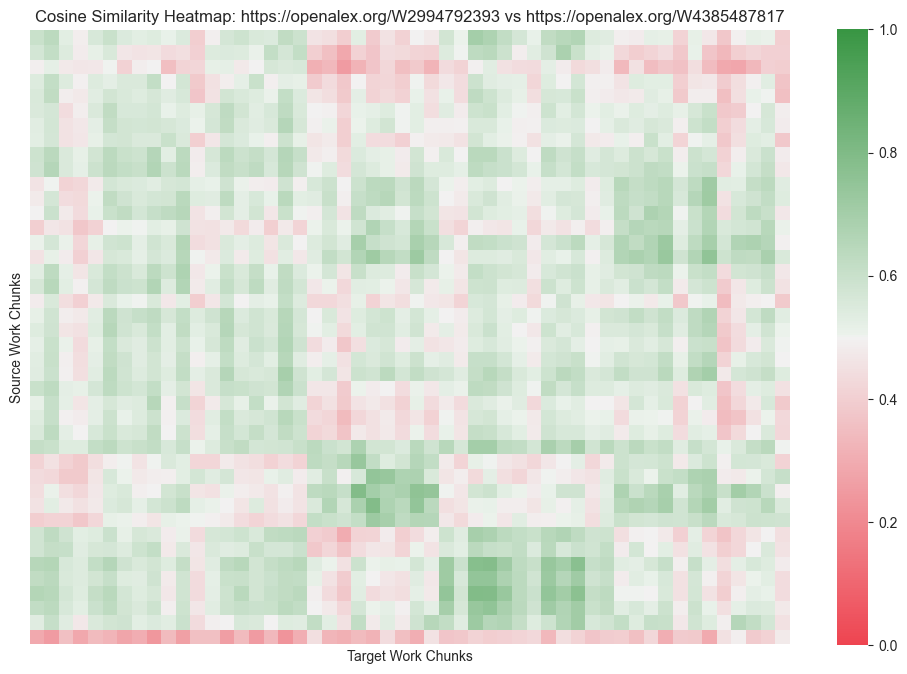

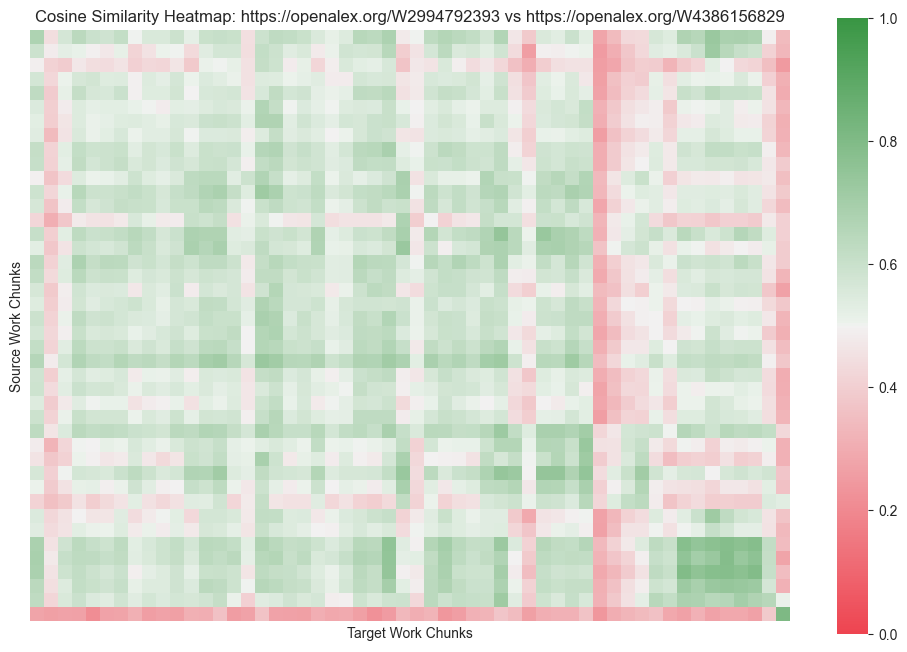

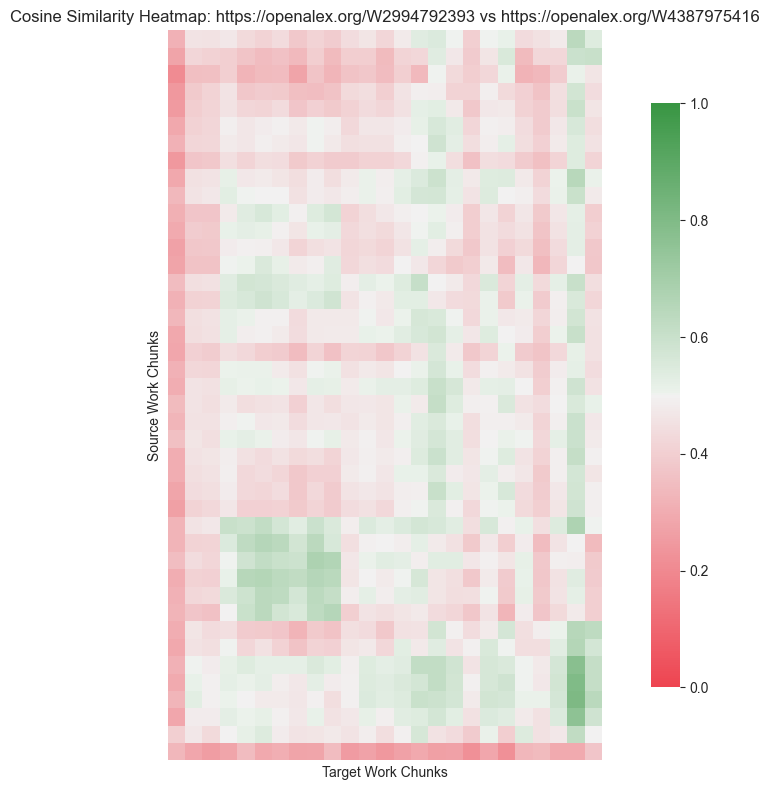

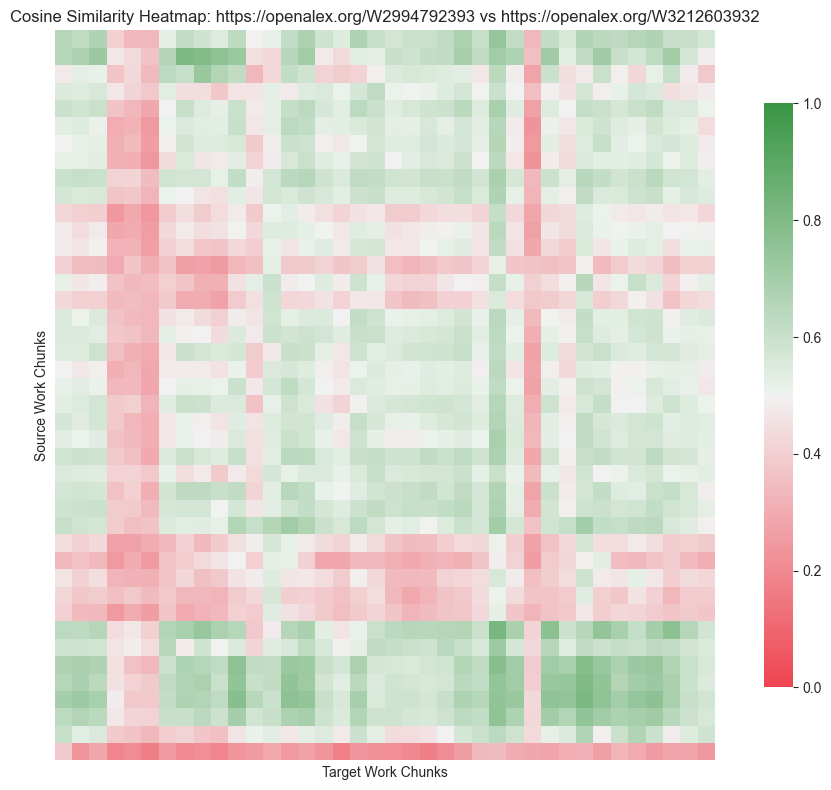

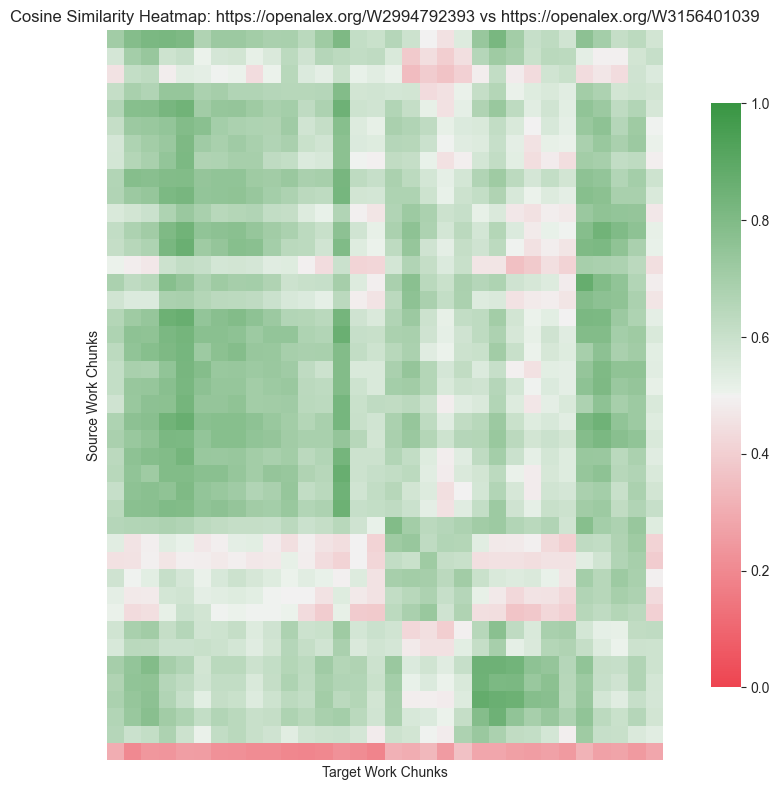

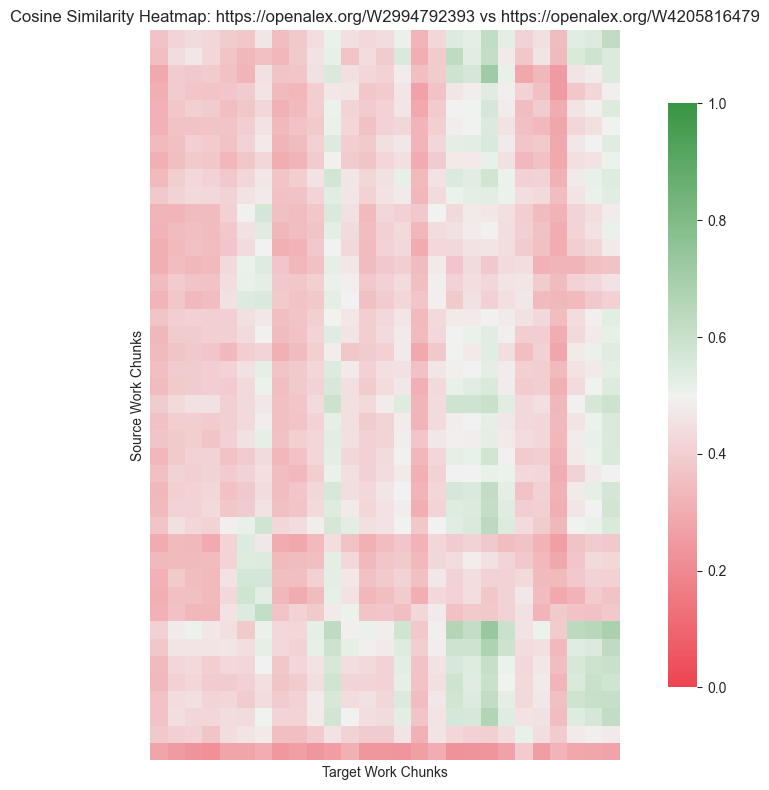

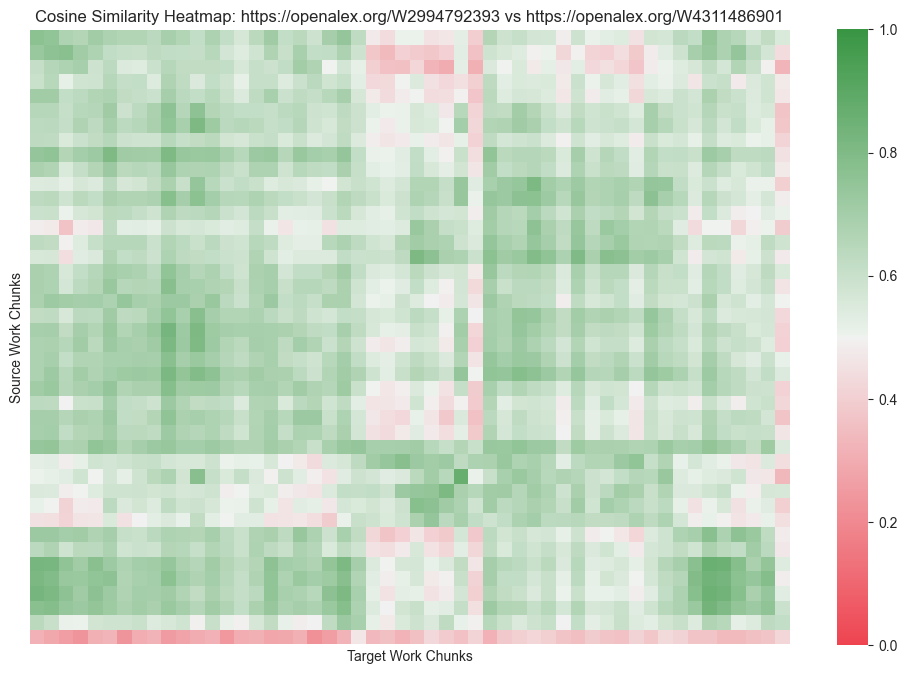

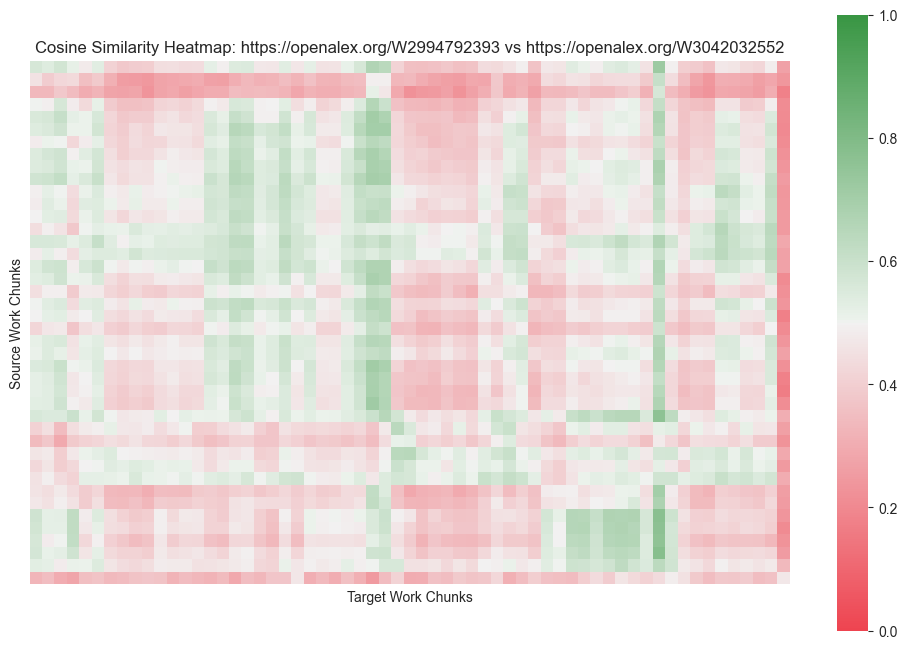

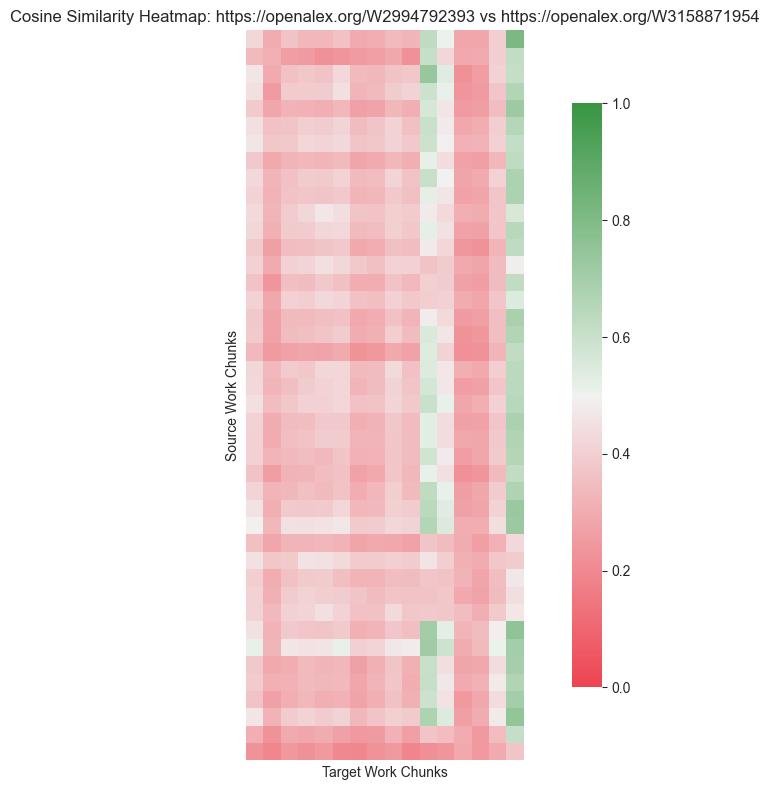

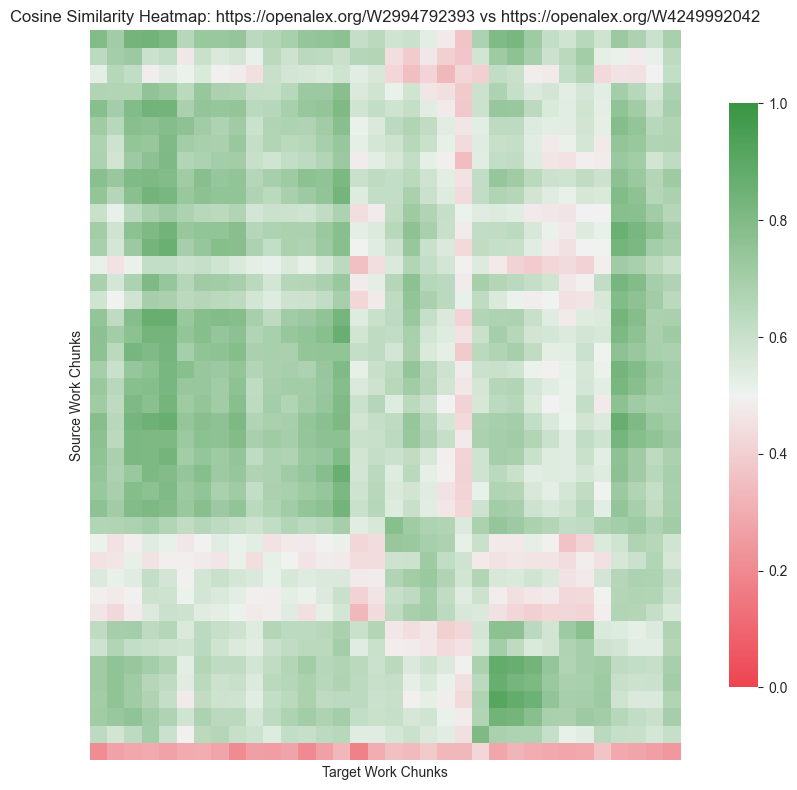

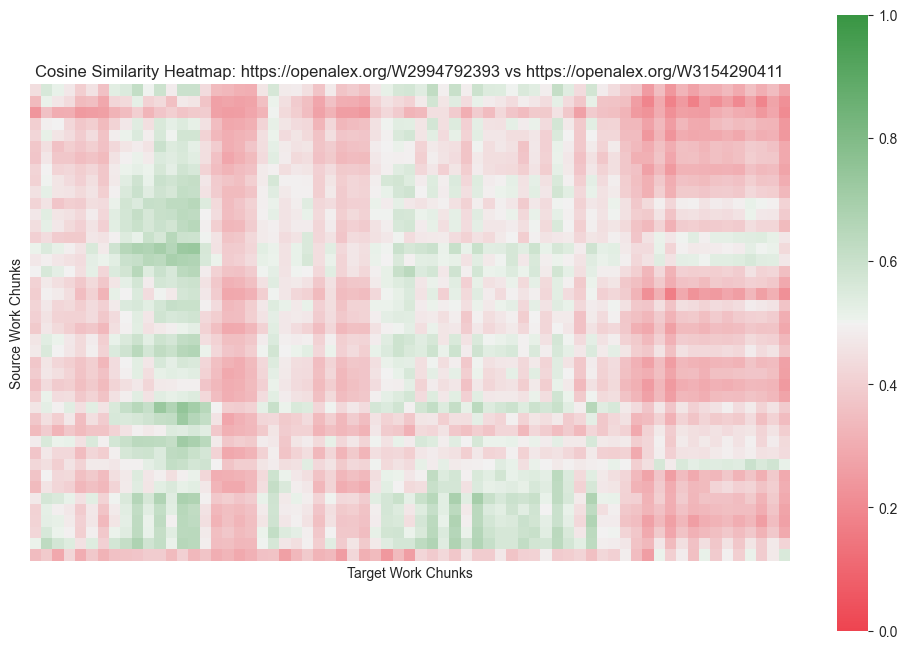

In [30]:
for work_id in CITATIONS:
    work_1 = FOCUS_PAPER
    work_2 = work_id
    
    plot_similarity_heatmap(work_1, work_2)

In [29]:
for work_id in CITATIONS:
    work_2 = FOCUS_PAPER
    work_1 = work_id

    # Get the embeddings for the two works
    embeddings_1 = EMBEDDINGS[work_1]
    embeddings_2 = EMBEDDINGS[work_2]

    # Convert the lists to numpy arrays
    vecs_1 = np.array(embeddings_1)
    vecs_2 = np.array(embeddings_2)

    # Calculate the cosine similarity matrix
    sim_matrix = cosine_similarity(vecs_1, vecs_2)

    # Flatten the similarity matrix into a 1D array
    sim_values = sim_matrix.flatten()

    # Sort the similarity values in descending order
    sorted_sim_values = np.sort(sim_values)[::-1]

    # Calculate the average of the 3 highest similarities
    highest_avg = np.mean(sorted_sim_values[:3])

    # Calculate the average of the 3 lowest similarities
    lowest_avg = np.mean(sorted_sim_values[-3:])

    print(f"Comparison between {work_1} and {work_2}:")
    print(f"Average of 3 highest similarities: {highest_avg:.3f}")
    print(f"Average of 3 lowest similarities: {lowest_avg:.3f}")
    print()

Comparison between https://openalex.org/W3190631166 and https://openalex.org/W2994792393:
Average of 3 highest similarities: 0.858
Average of 3 lowest similarities: 0.170

Comparison between https://openalex.org/W3155261830 and https://openalex.org/W2994792393:
Average of 3 highest similarities: 0.823
Average of 3 lowest similarities: 0.219

Comparison between https://openalex.org/W4213233537 and https://openalex.org/W2994792393:
Average of 3 highest similarities: 0.877
Average of 3 lowest similarities: 0.184

Comparison between https://openalex.org/W3161934607 and https://openalex.org/W2994792393:
Average of 3 highest similarities: 0.675
Average of 3 lowest similarities: 0.201

Comparison between https://openalex.org/W3196498124 and https://openalex.org/W2994792393:
Average of 3 highest similarities: 0.682
Average of 3 lowest similarities: 0.216

Comparison between https://openalex.org/W3004924525 and https://openalex.org/W2994792393:
Average of 3 highest similarities: 0.788
Average o

In [33]:
from scipy.ndimage import gaussian_filter

def plot_similarity_surface(work_1: str, work_2: str, sigma: float = 1.0):
    """
    Plot a 3D surface plot of the cosine similarity matrix between two works with smoothing.
    
    :param work_1: ID of the first work.
    :param work_2: ID of the second work.
    :param sigma: Standard deviation for Gaussian kernel (default: 1.0).
    """
    # Get the embeddings for the source and target works
    source_embeddings = EMBEDDINGS[work_1]
    target_embeddings = EMBEDDINGS[work_2]

    # Convert the lists to numpy arrays
    source_vectors = np.array(source_embeddings)
    target_vectors = np.array(target_embeddings)

    # Calculate the cosine similarity matrix
    similarity_matrix = cosine_similarity(source_vectors, target_vectors)

    # Apply Gaussian smoothing to the similarity matrix
    smoothed_matrix = gaussian_filter(similarity_matrix, sigma=sigma)

    # Create a figure and 3D axes
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create x, y coordinates for the surface plot
    x = np.arange(smoothed_matrix.shape[1])
    y = np.arange(smoothed_matrix.shape[0])
    X, Y = np.meshgrid(x, y)

    # Plot the 3D surface
    surf = ax.plot_surface(X, Y, smoothed_matrix, cmap='coolwarm', linewidth=0, antialiased=False)

    # Customize the plot
    ax.set_title(f"Cosine Similarity Surface Plot: {work_1} vs {work_2}")
    ax.set_xlabel("Target Work Chunks")
    ax.set_ylabel("Source Work Chunks")
    ax.set_zlabel("Cosine Similarity")

    # Add a color bar
    fig.colorbar(surf, shrink=0.5, aspect=5)

    # Adjust the viewing angle
    ax.view_init(elev=20, azim=45)

    plt.tight_layout()
    plt.show()

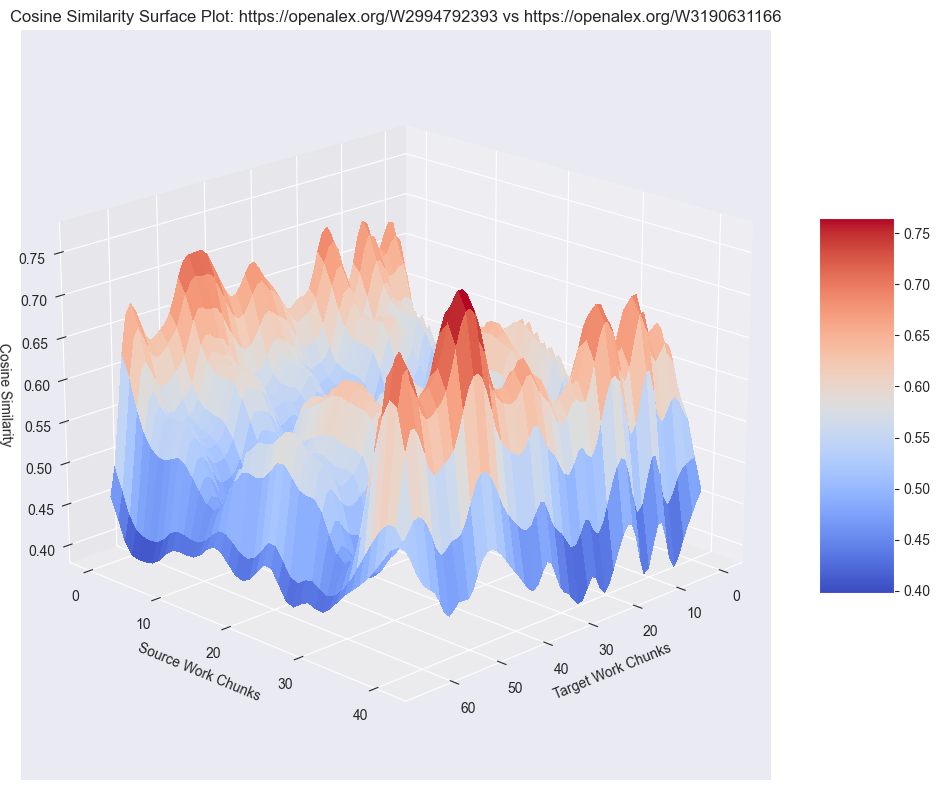

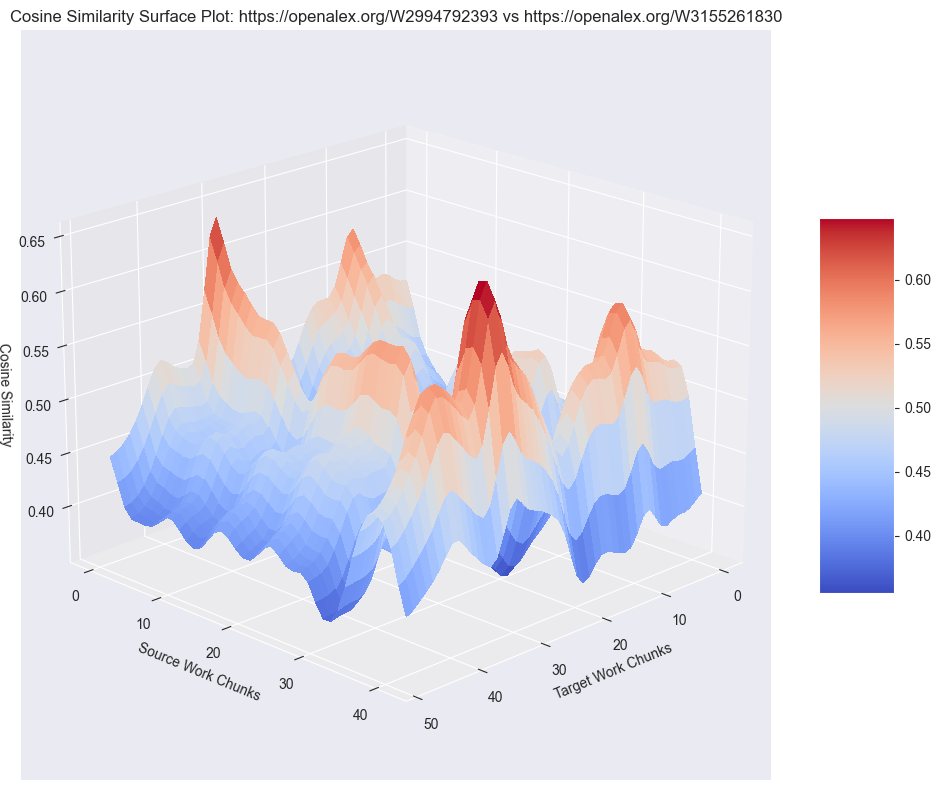

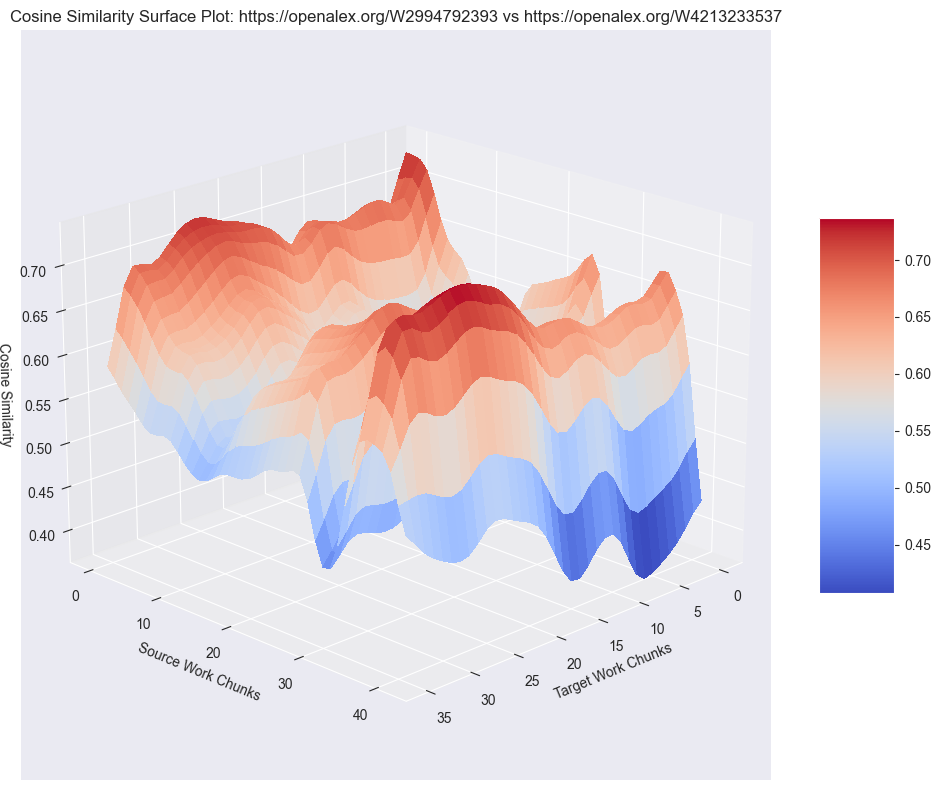

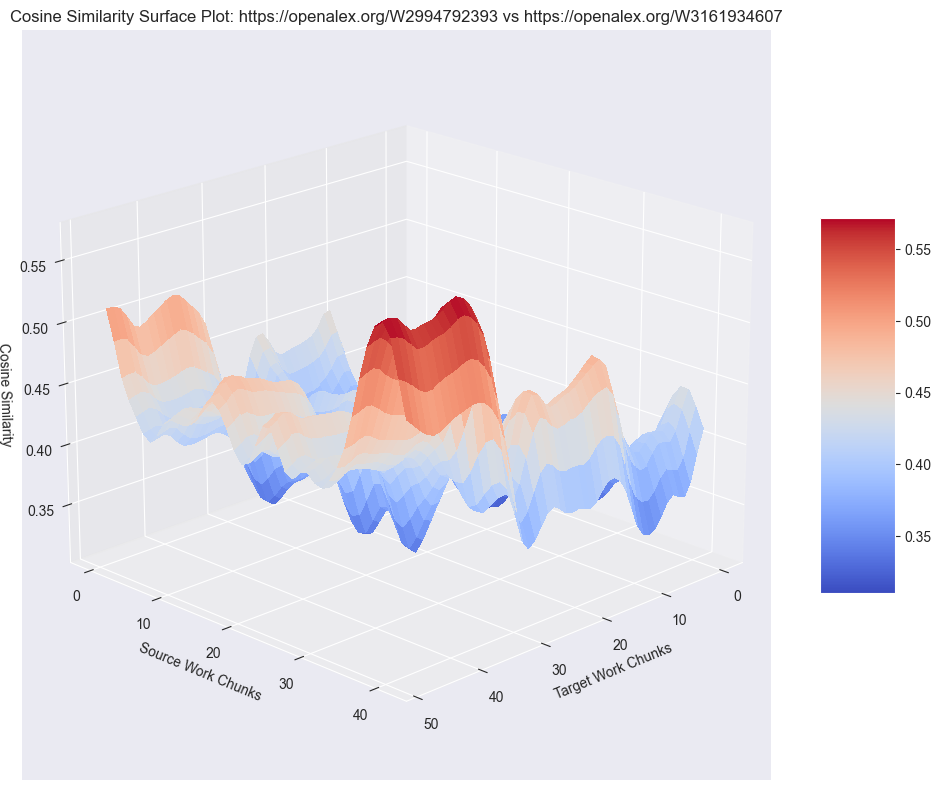

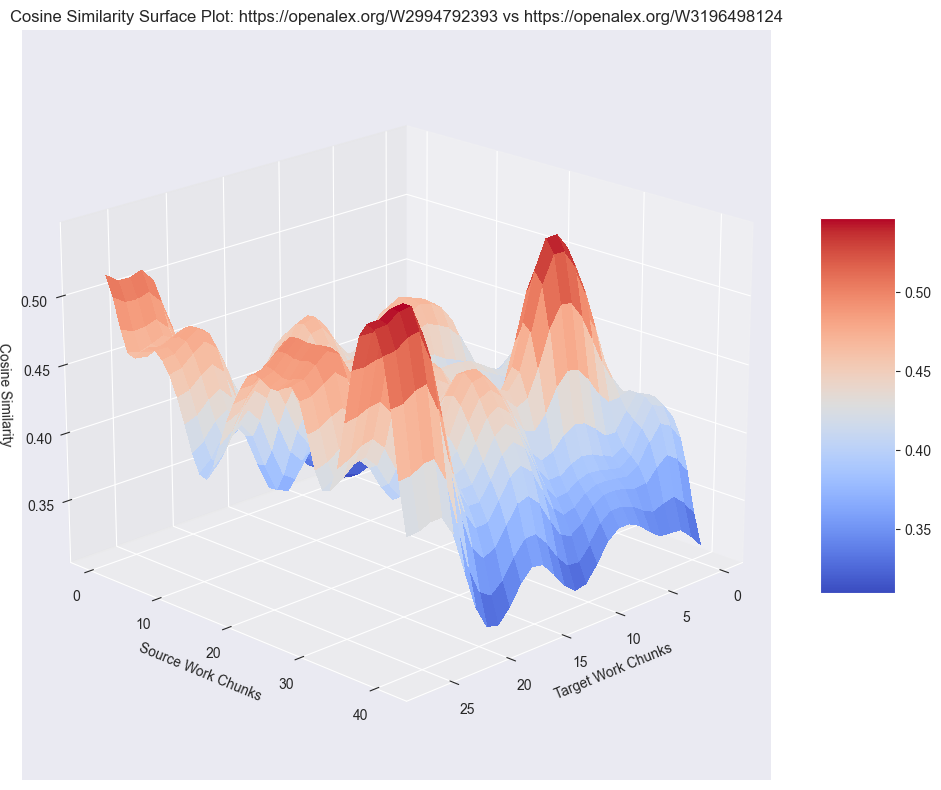

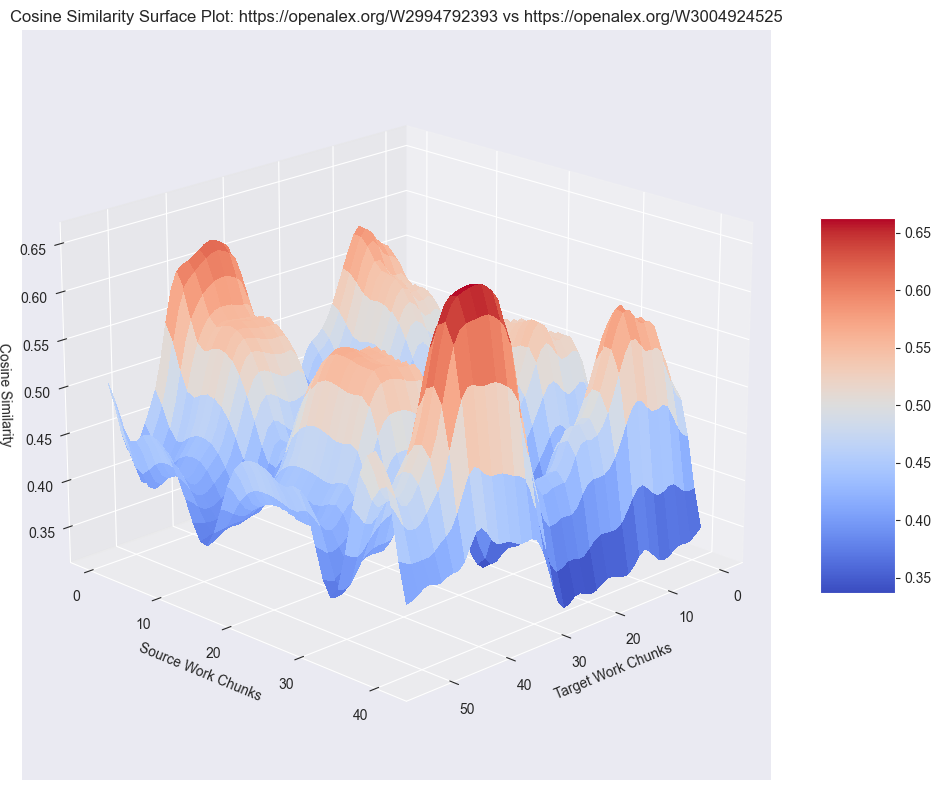

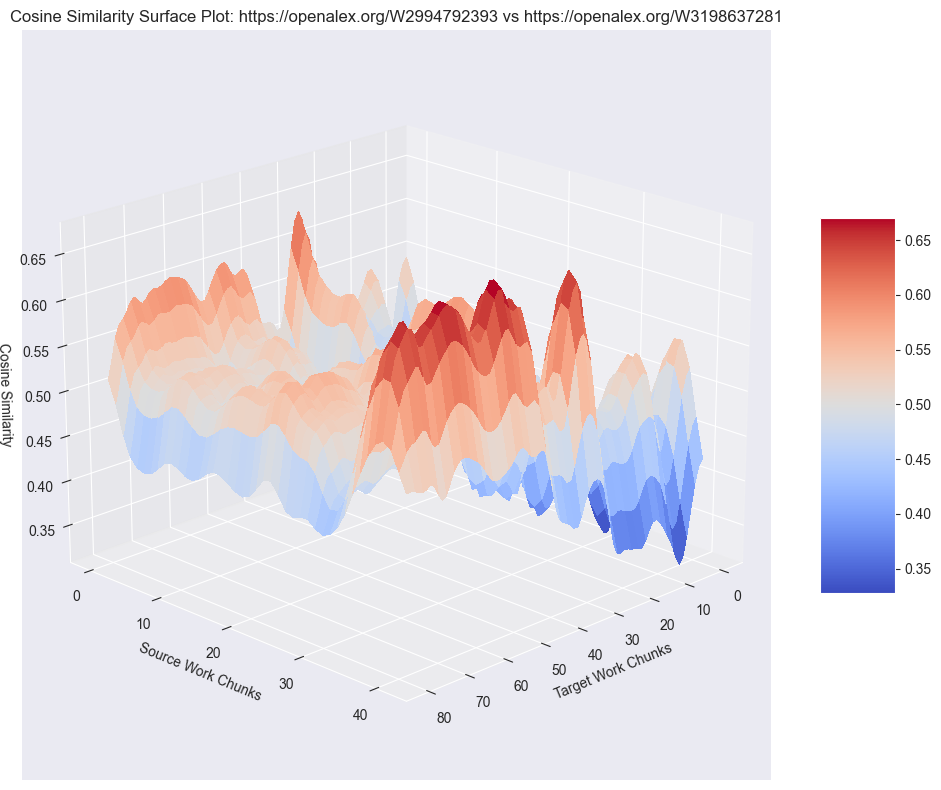

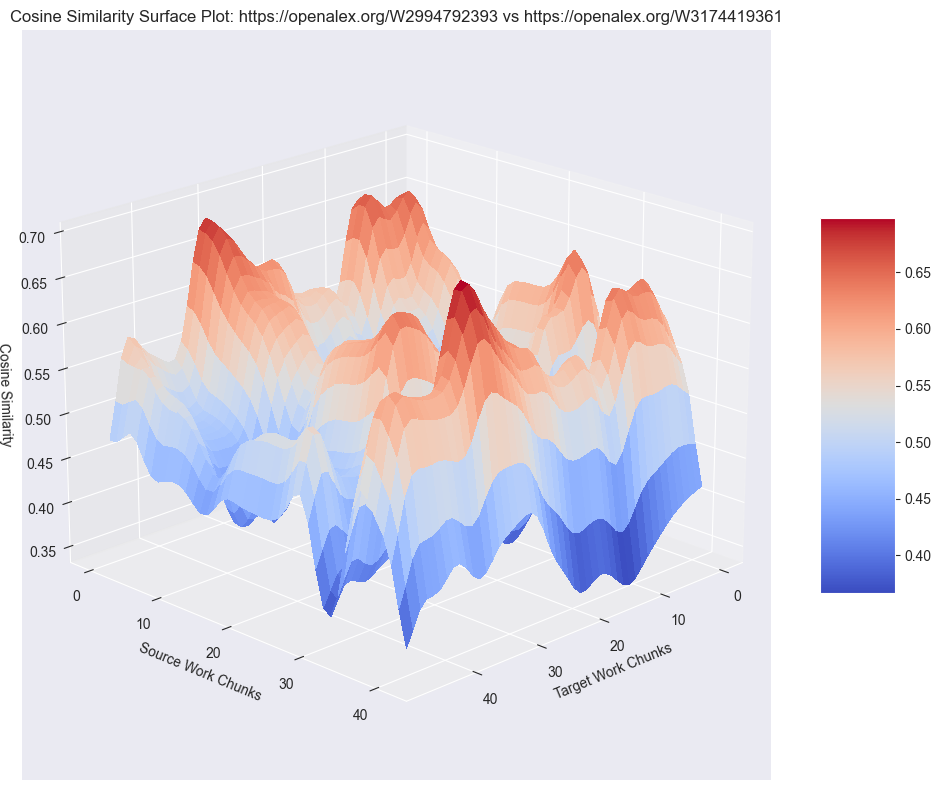

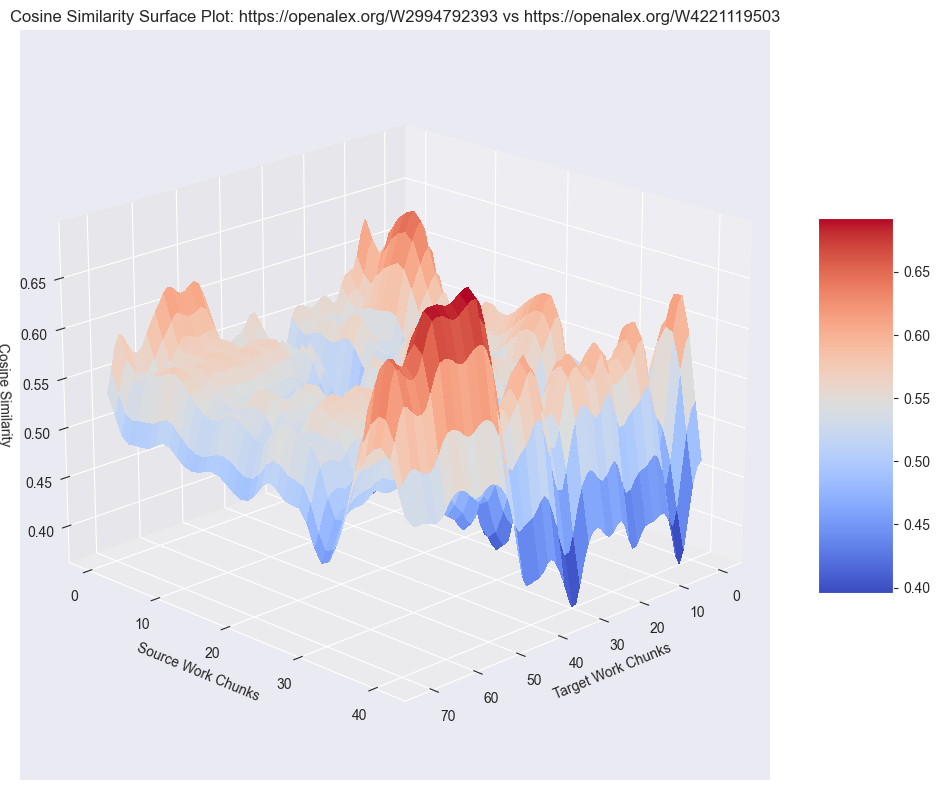

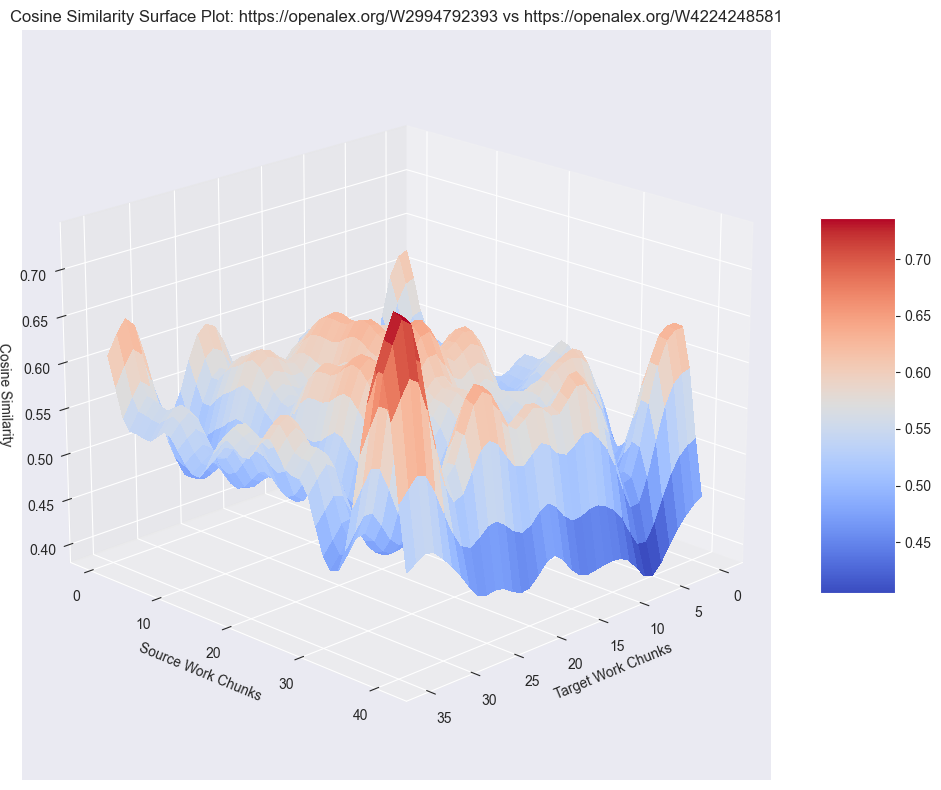

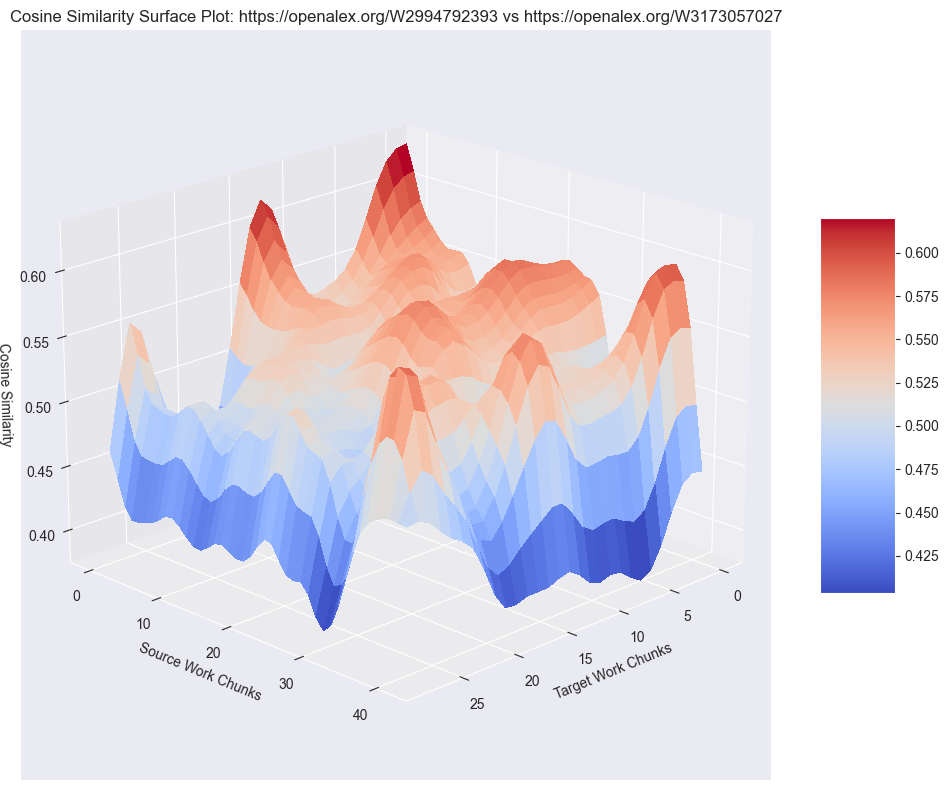

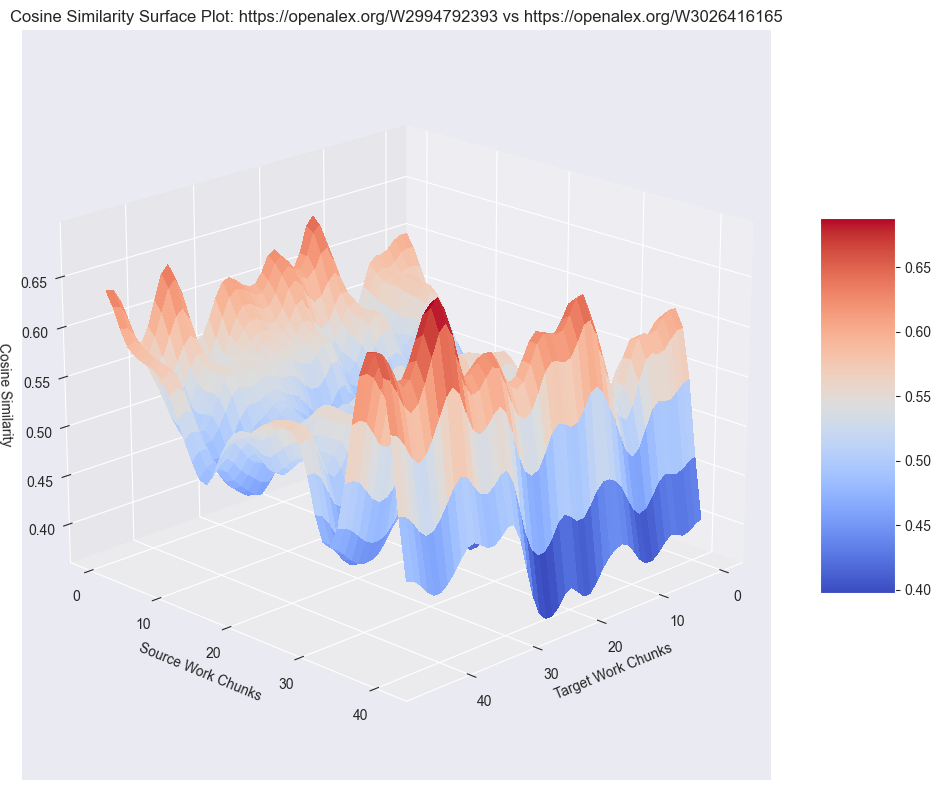

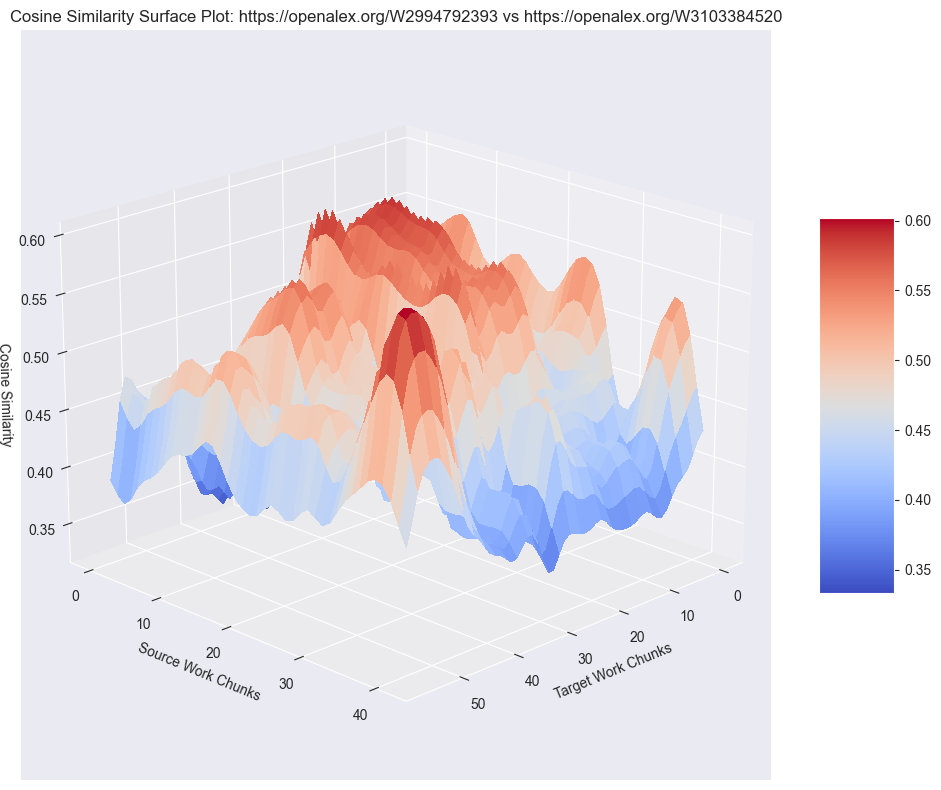

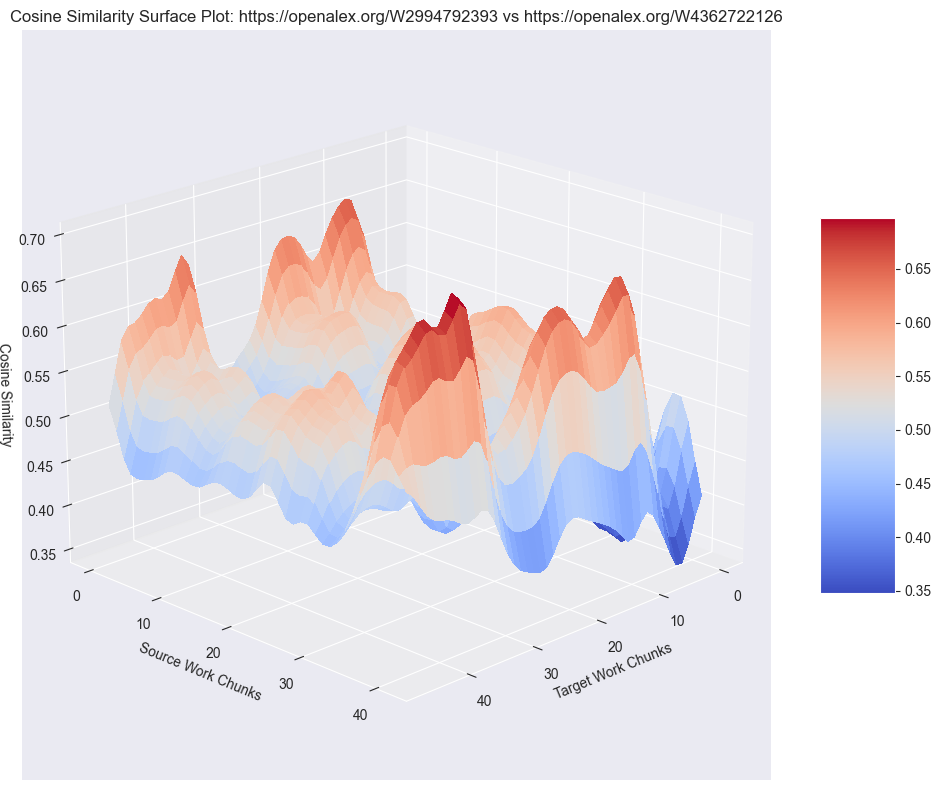

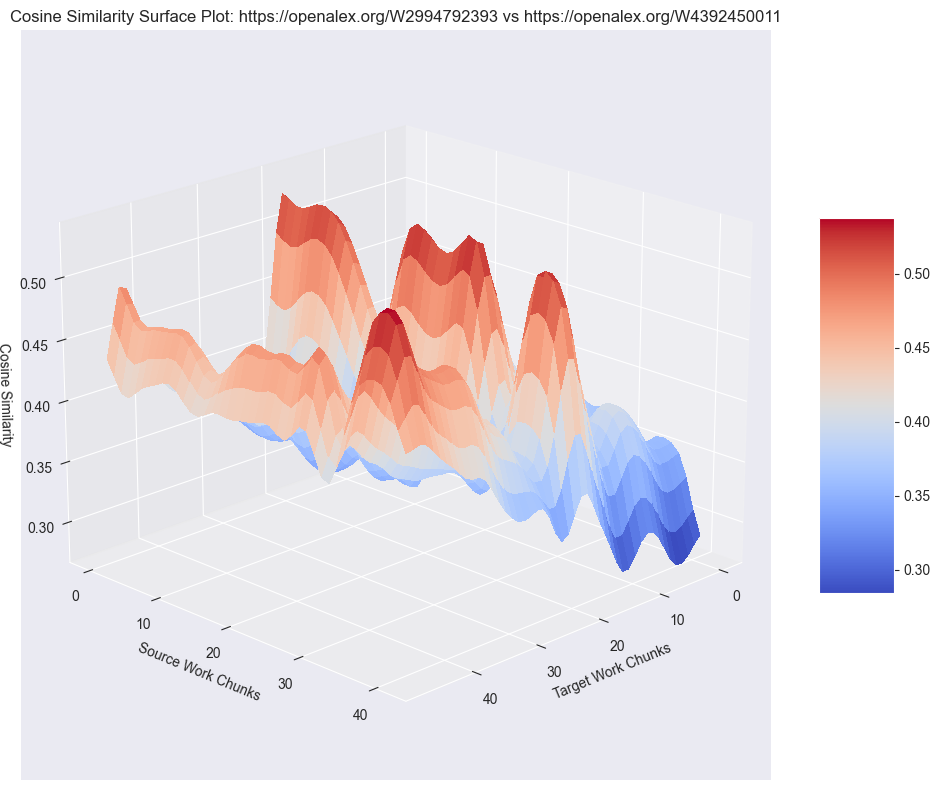

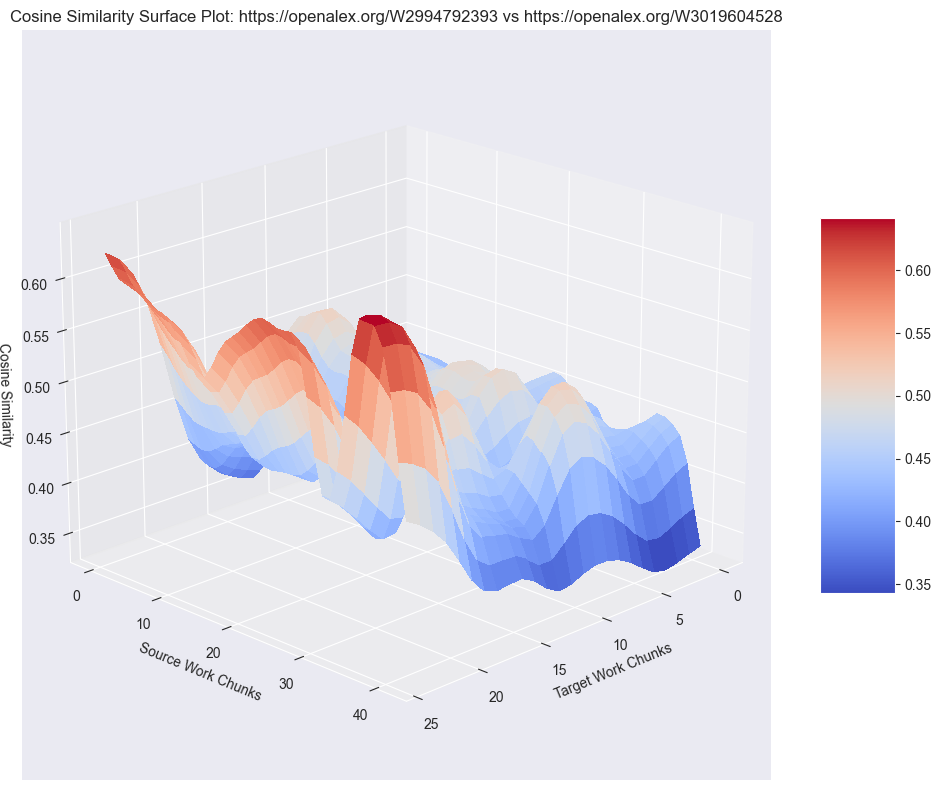

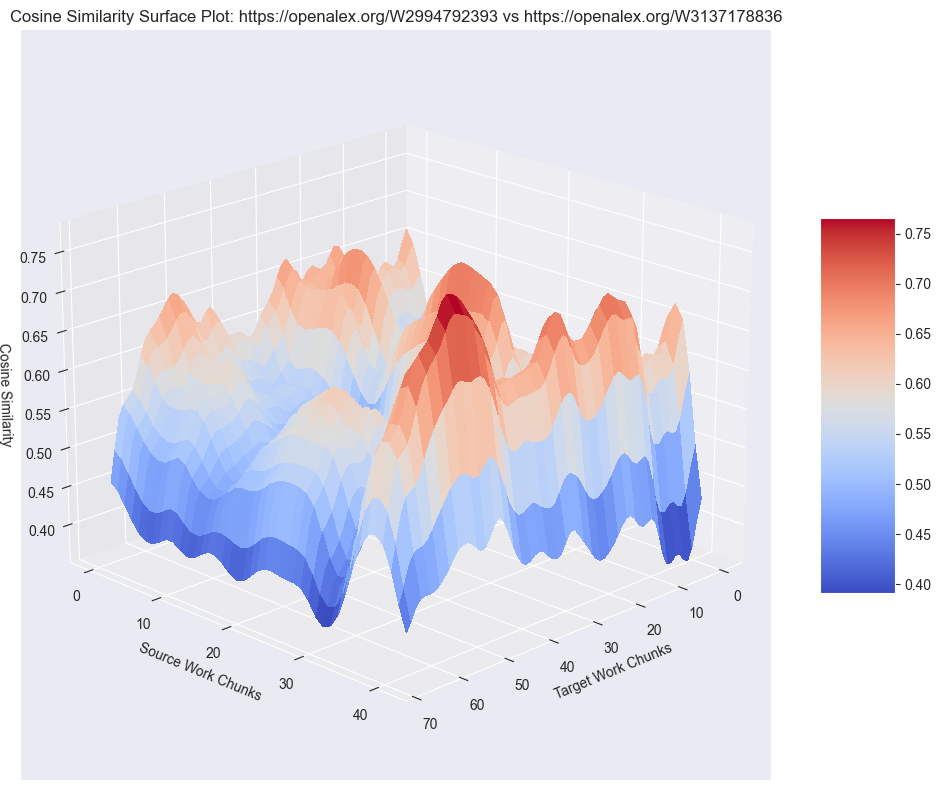

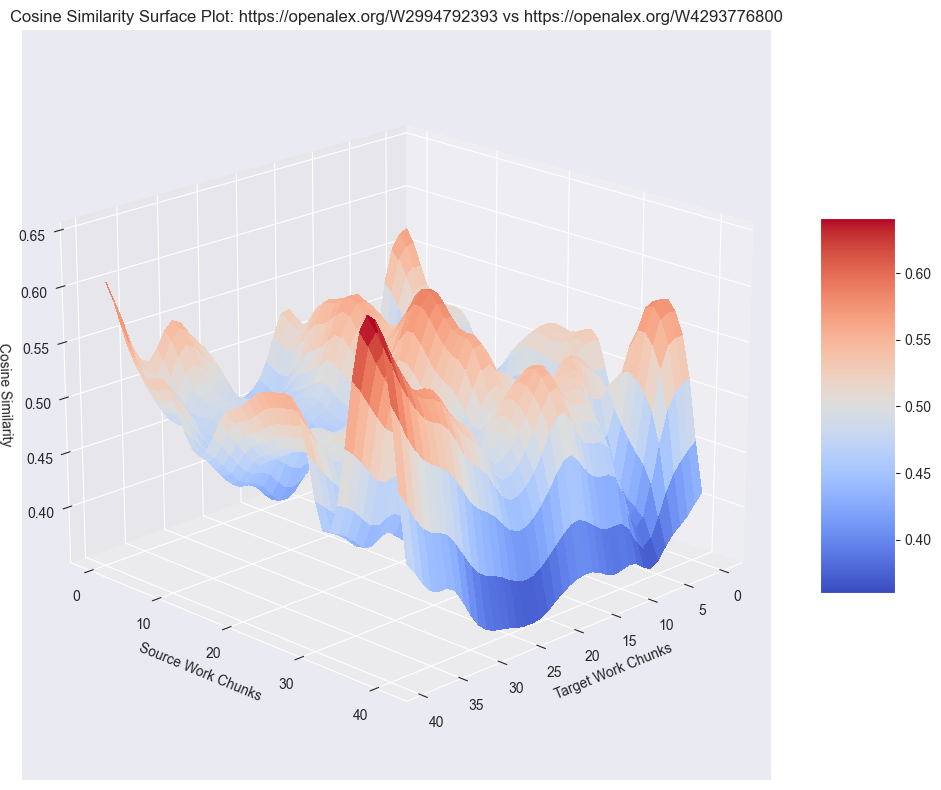

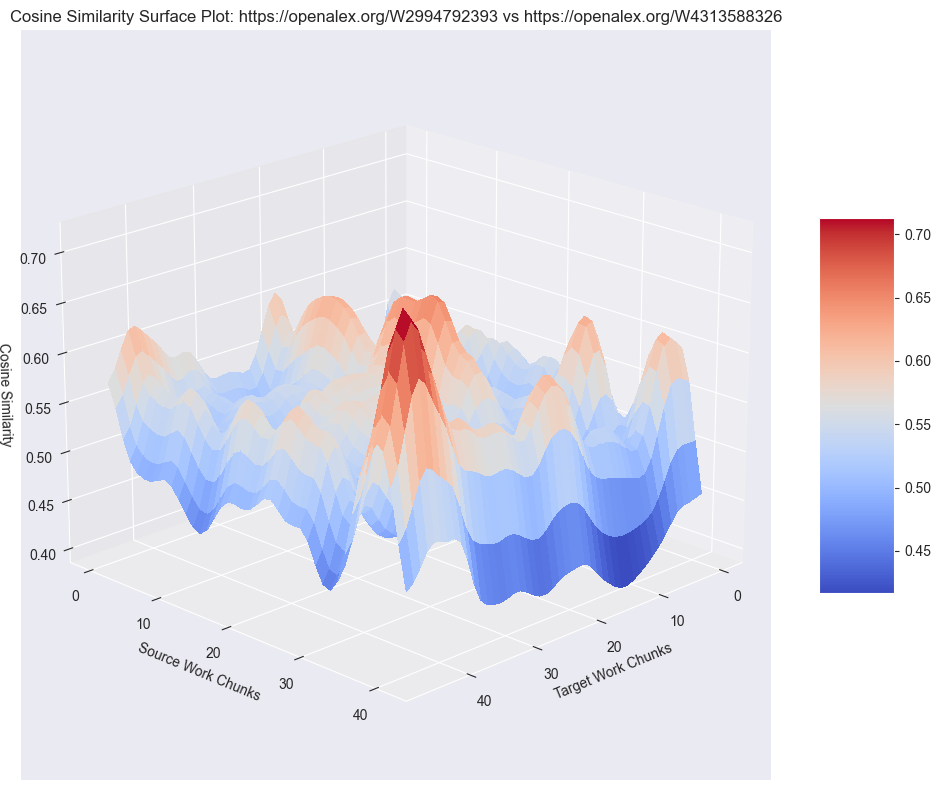

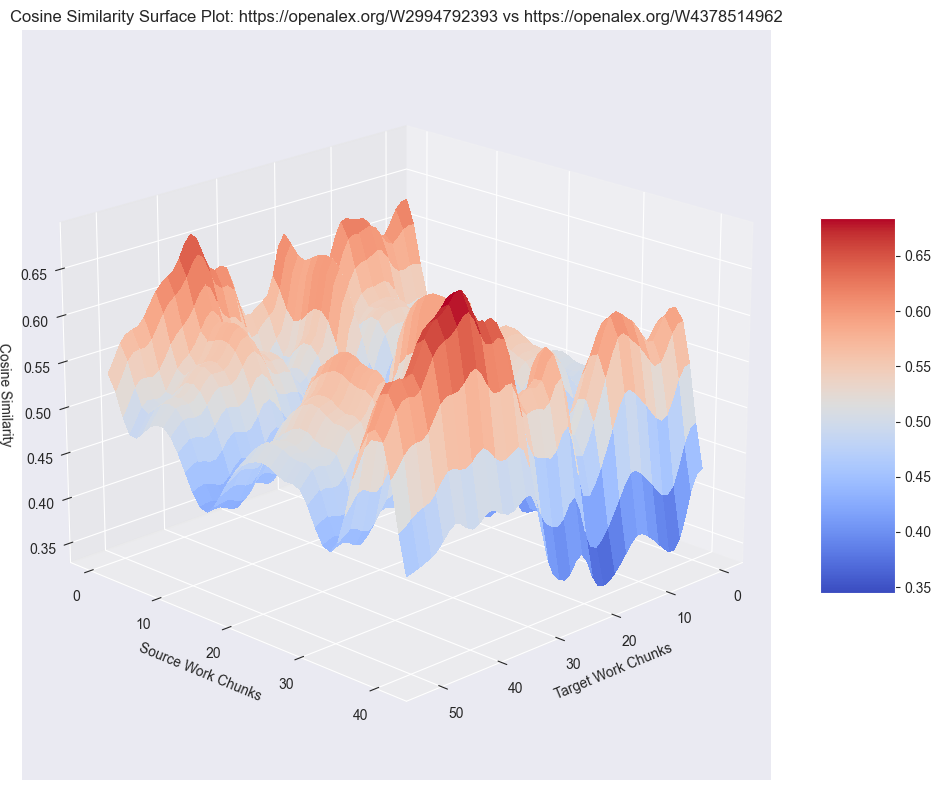

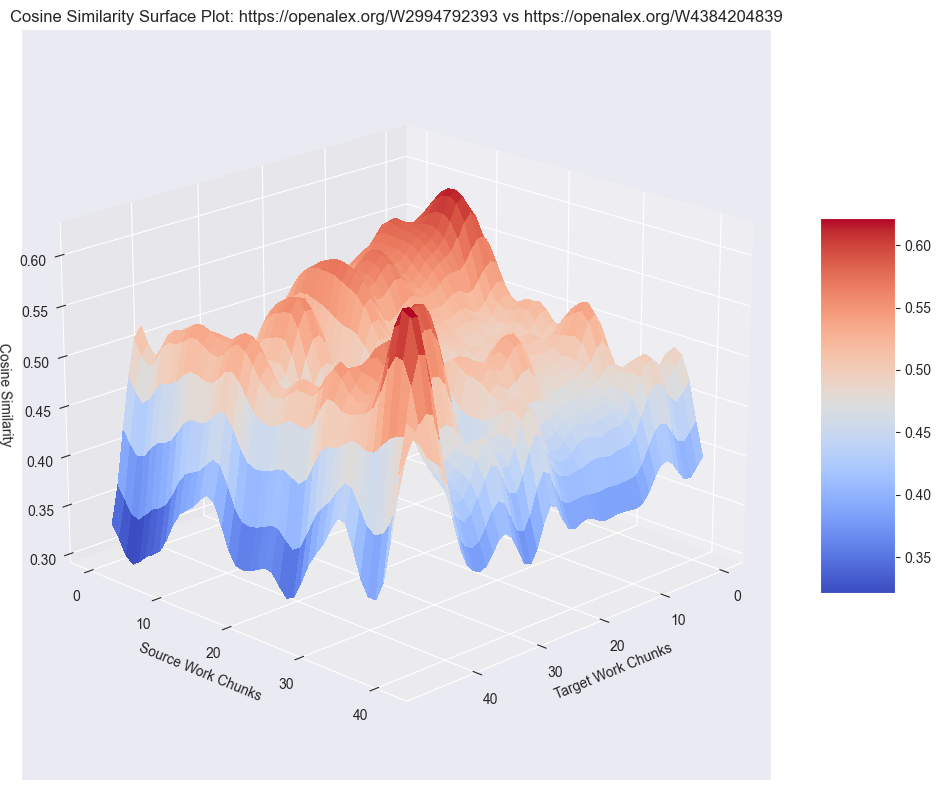

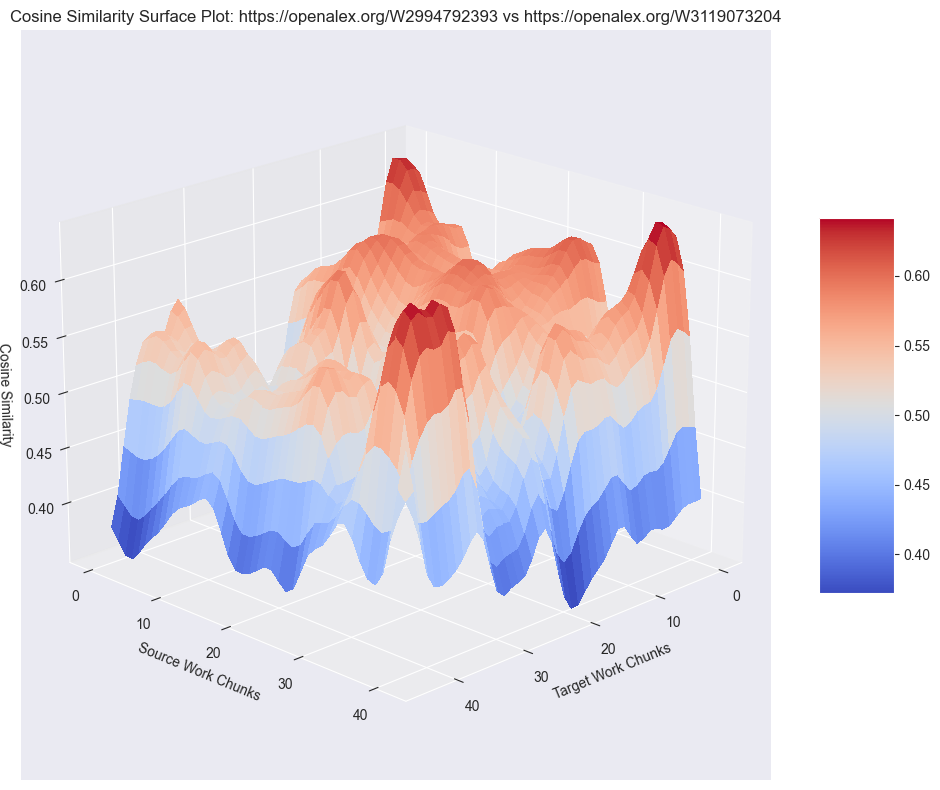

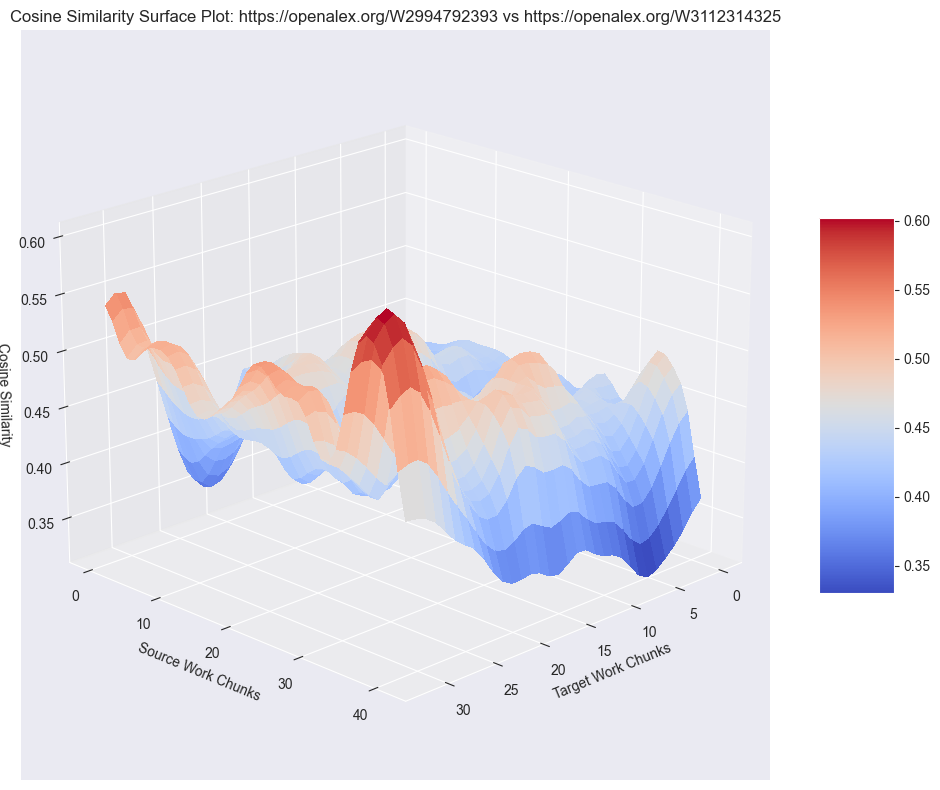

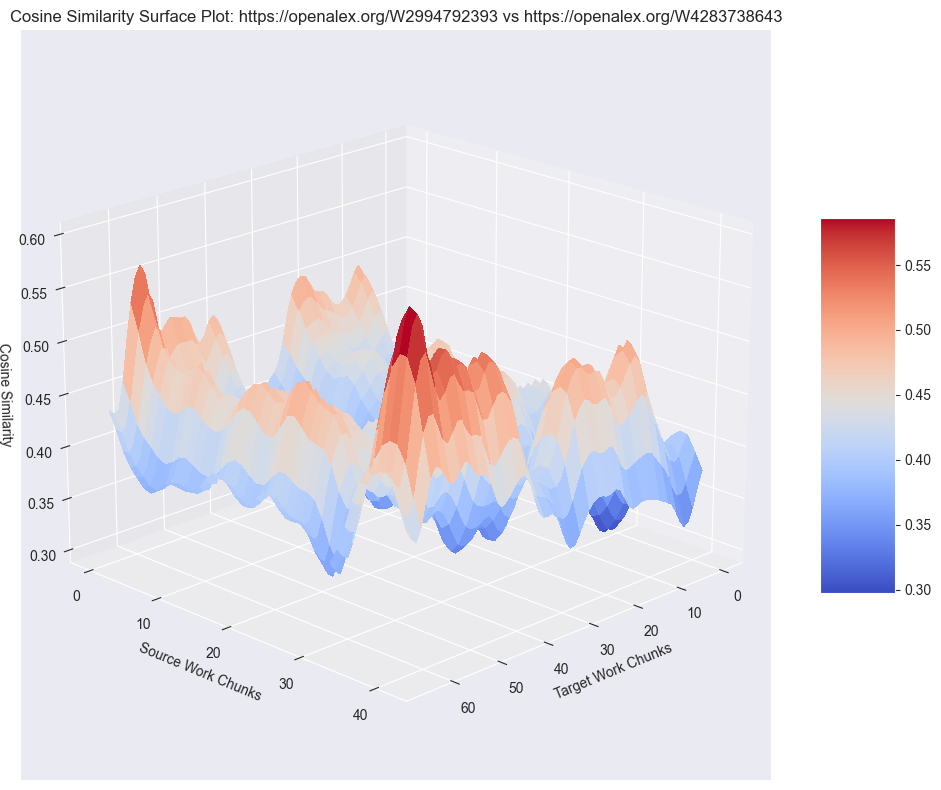

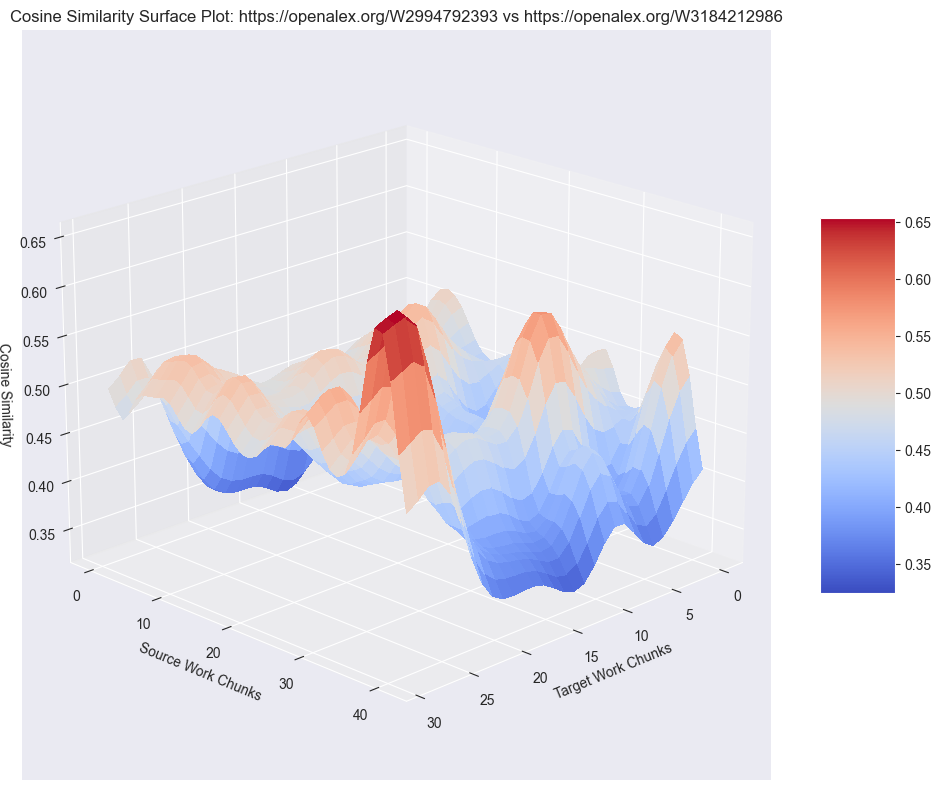

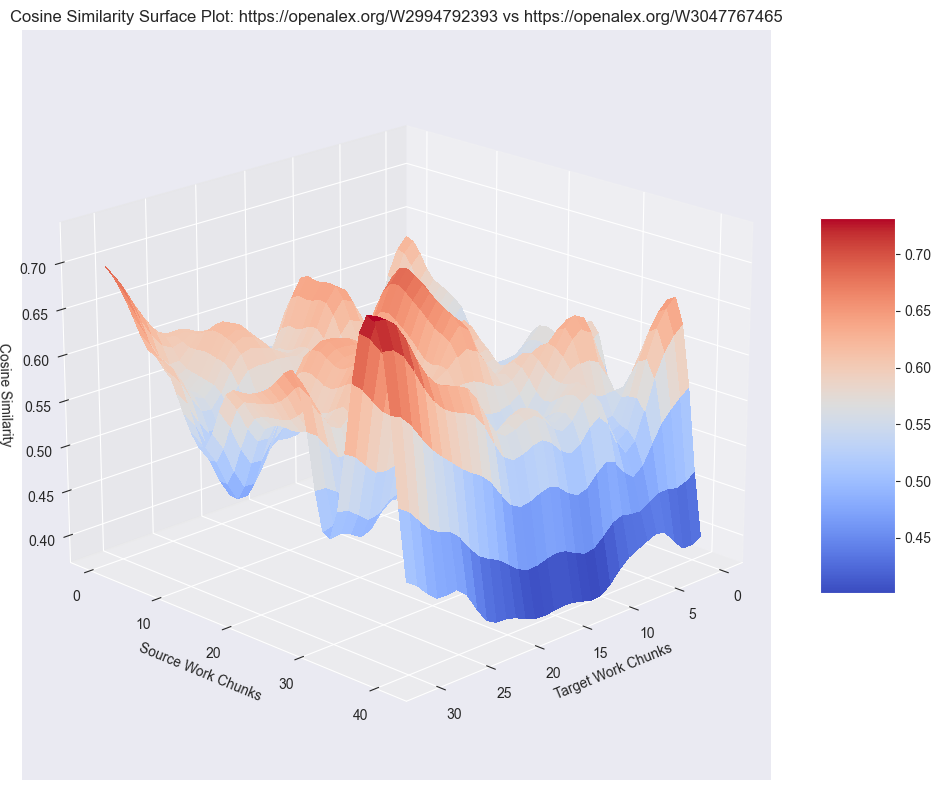

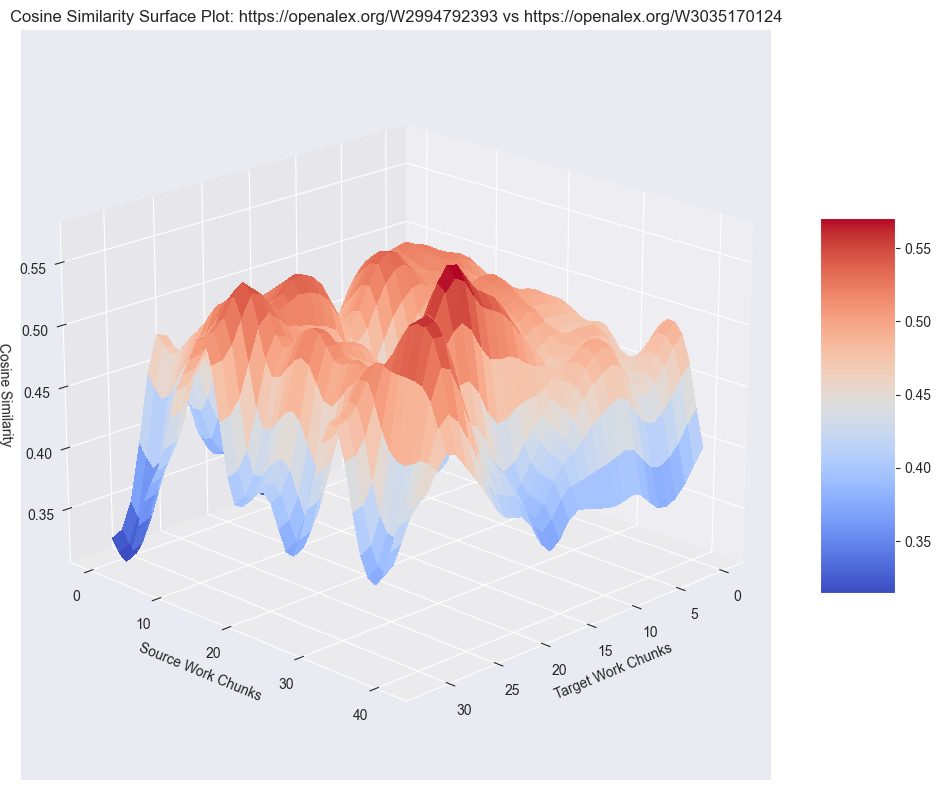

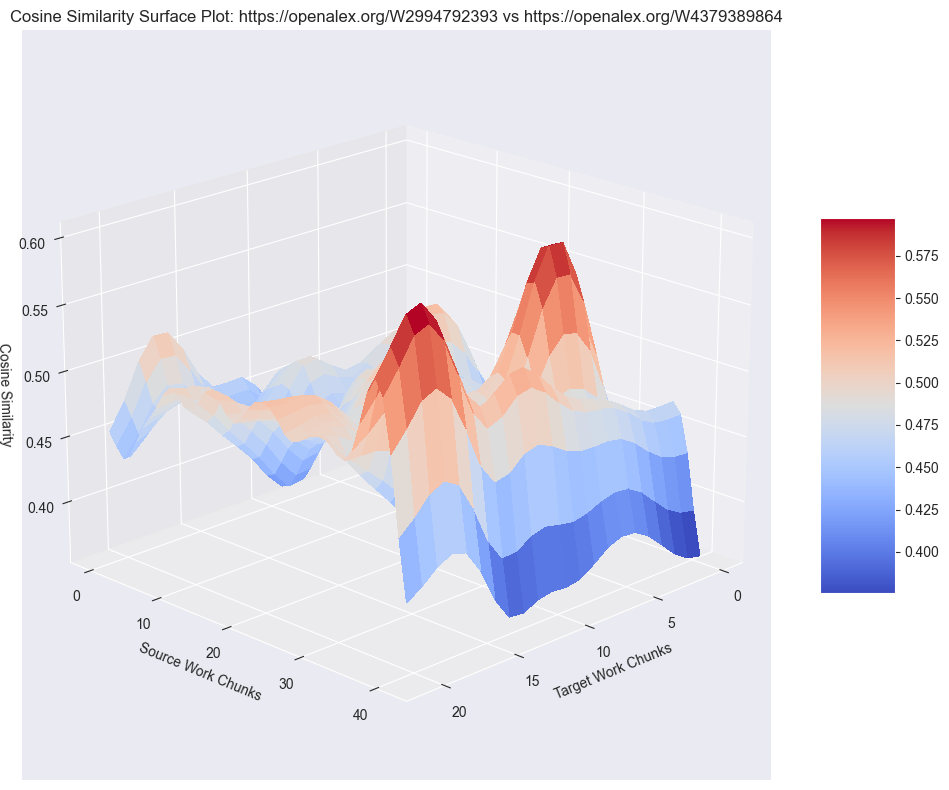

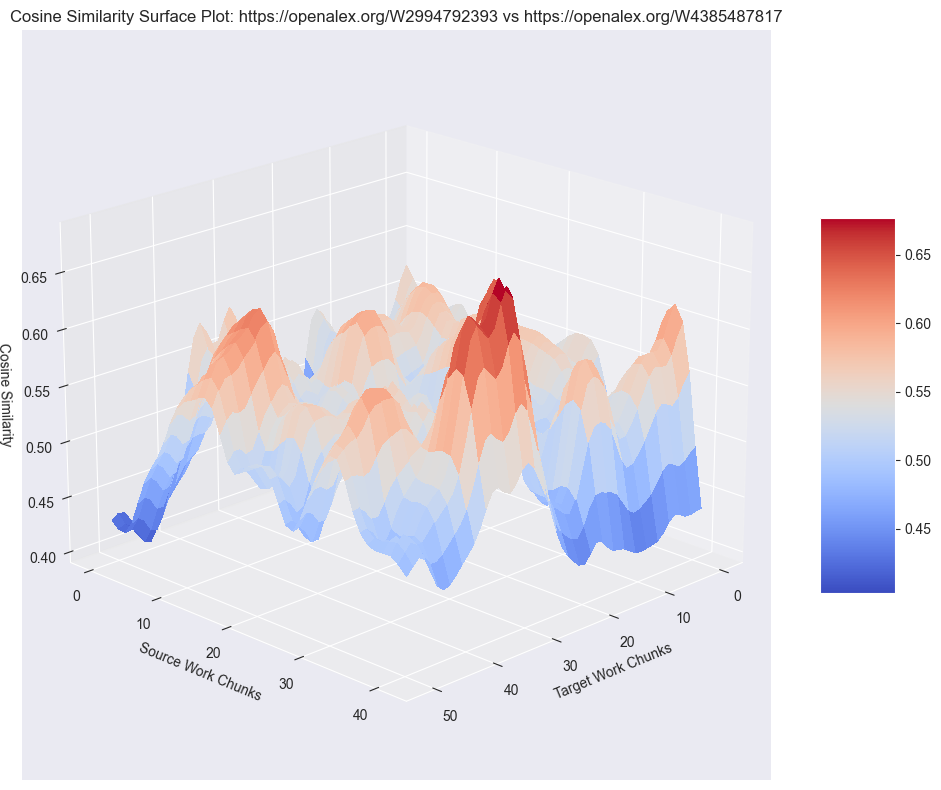

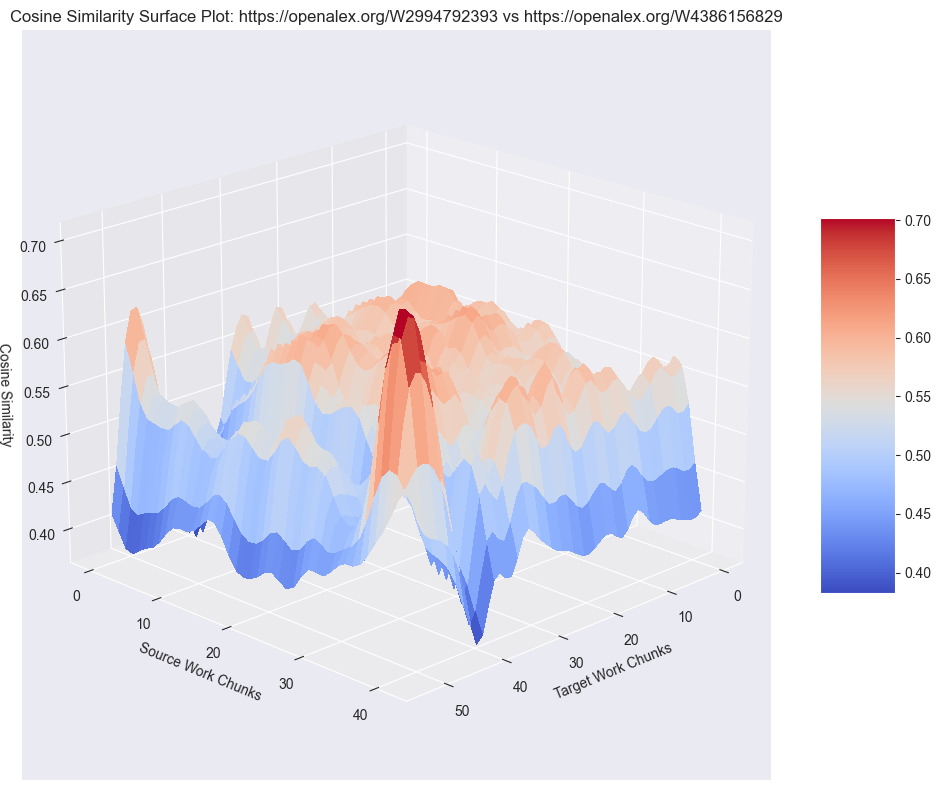

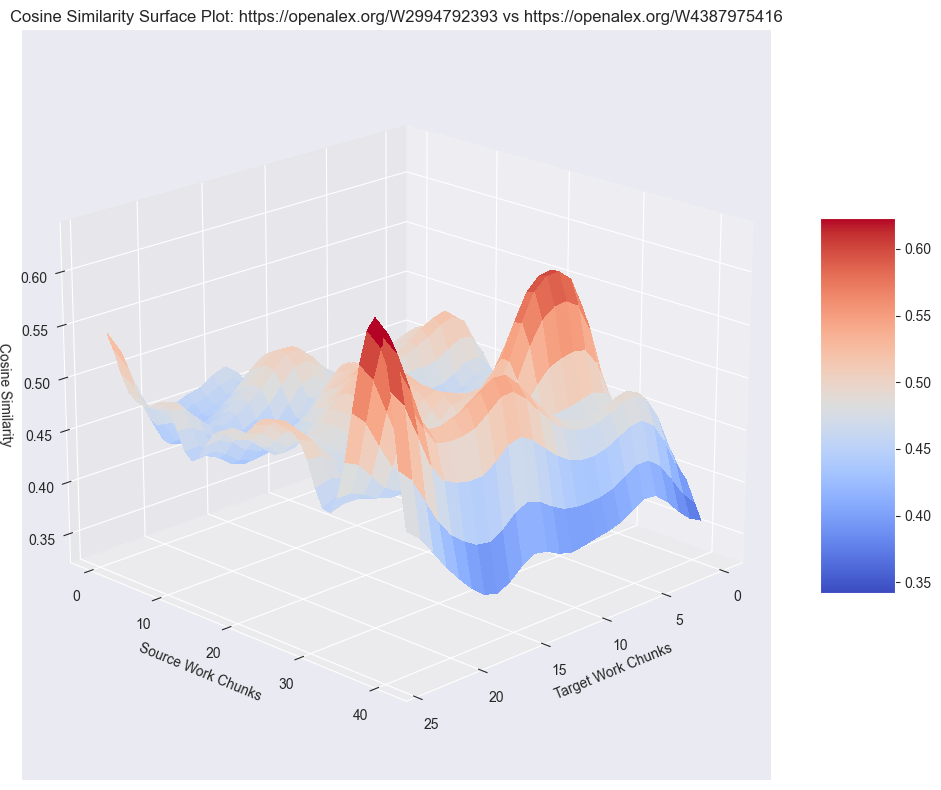

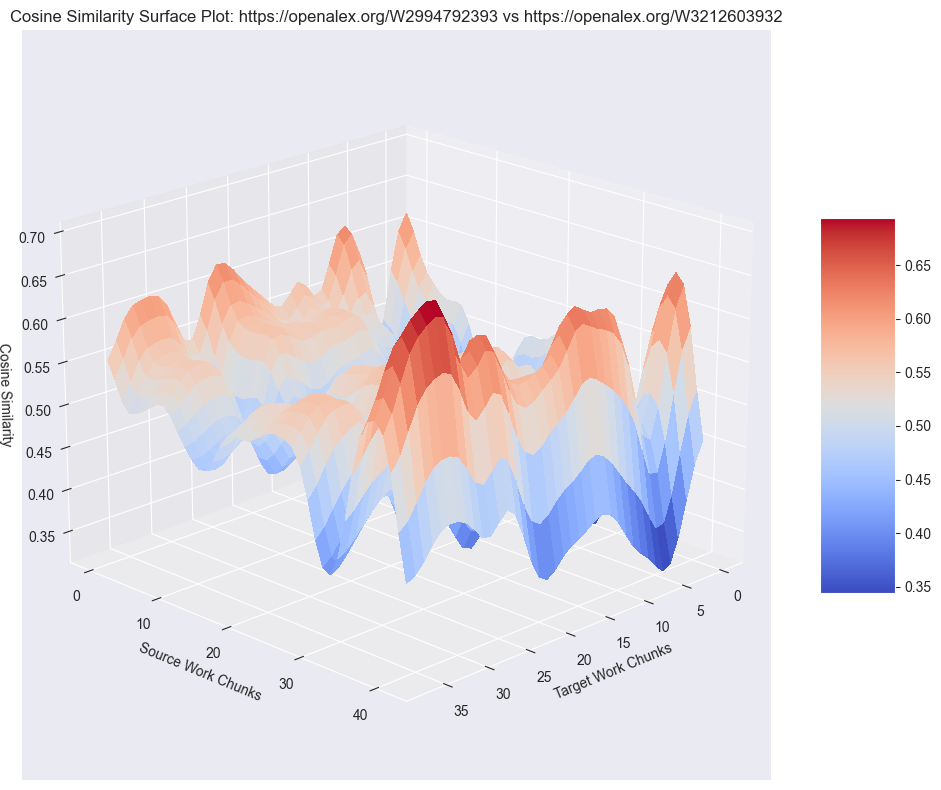

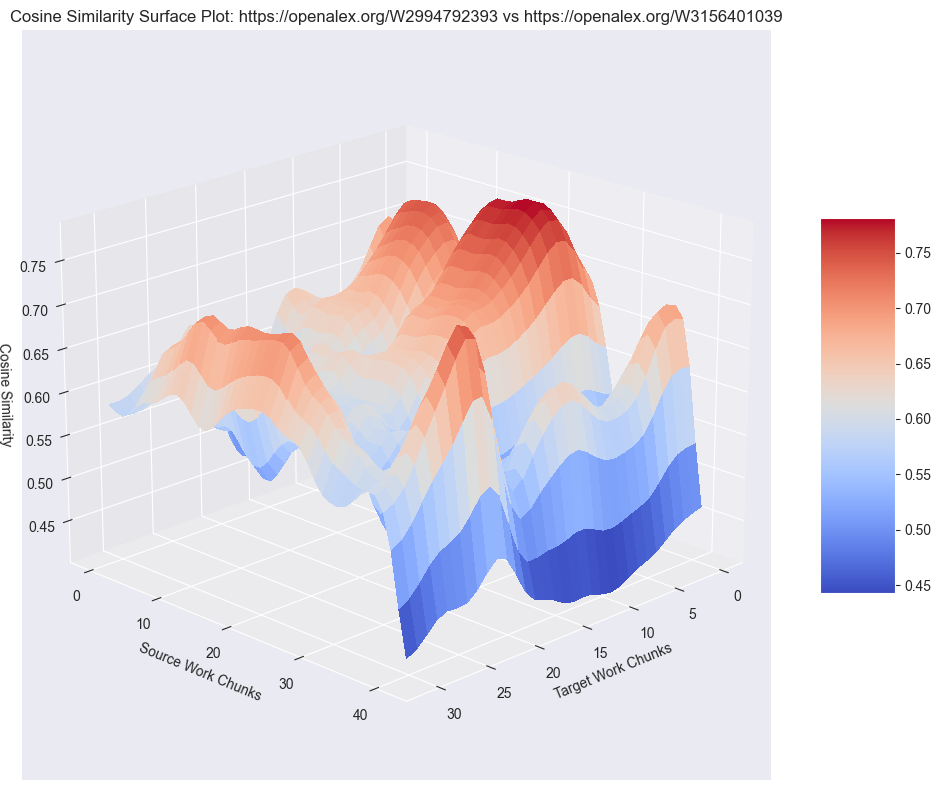

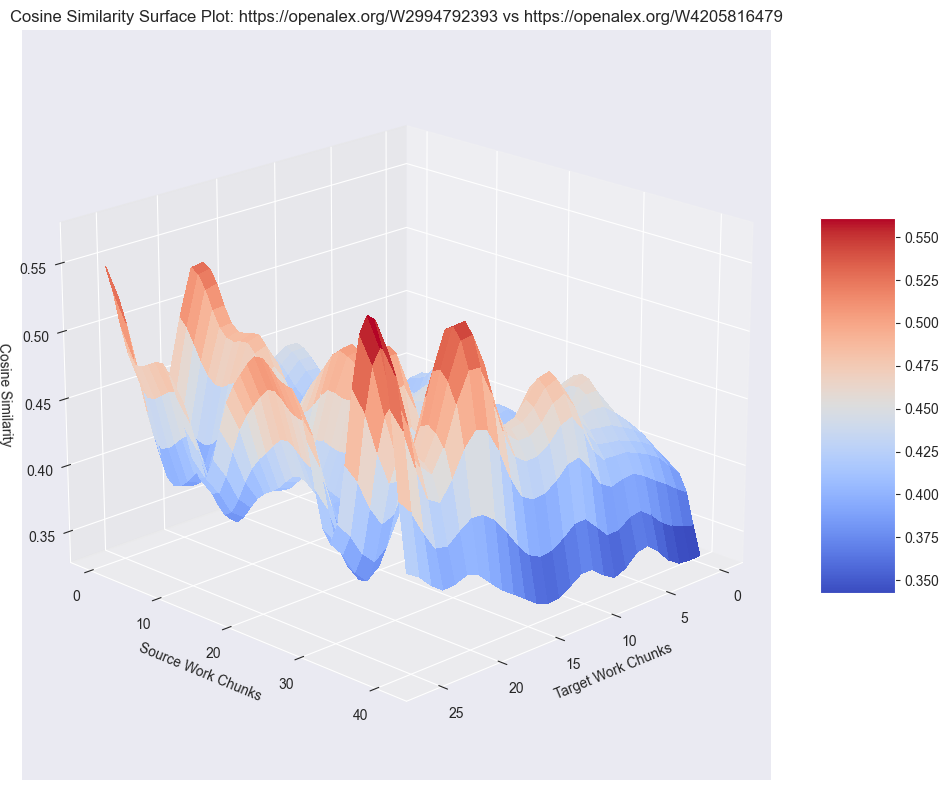

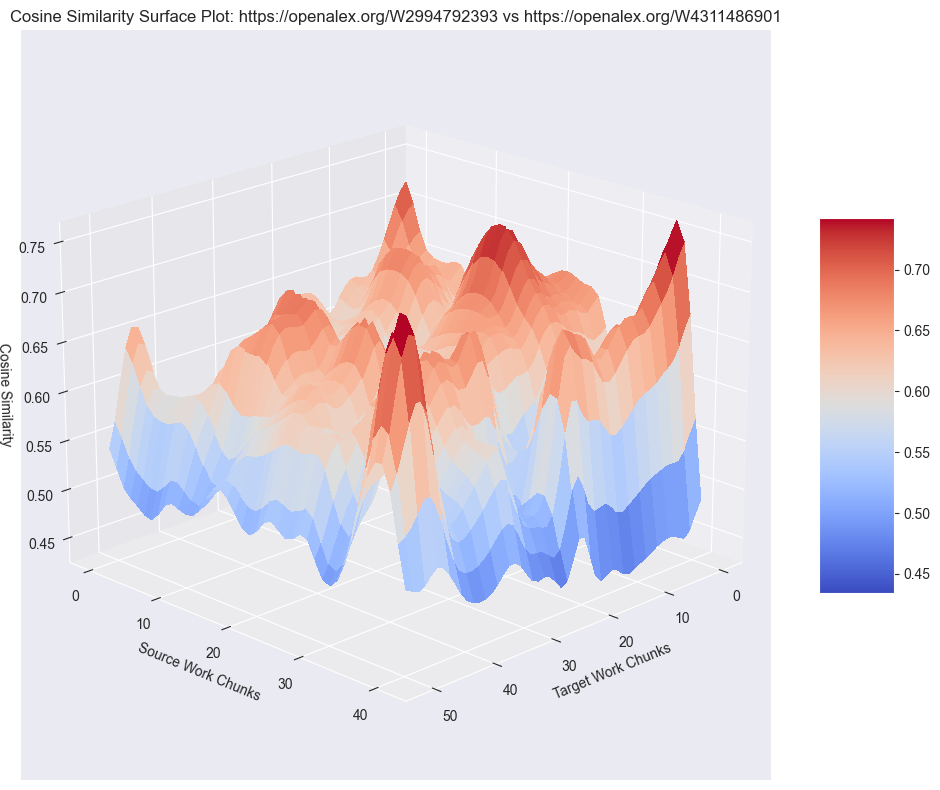

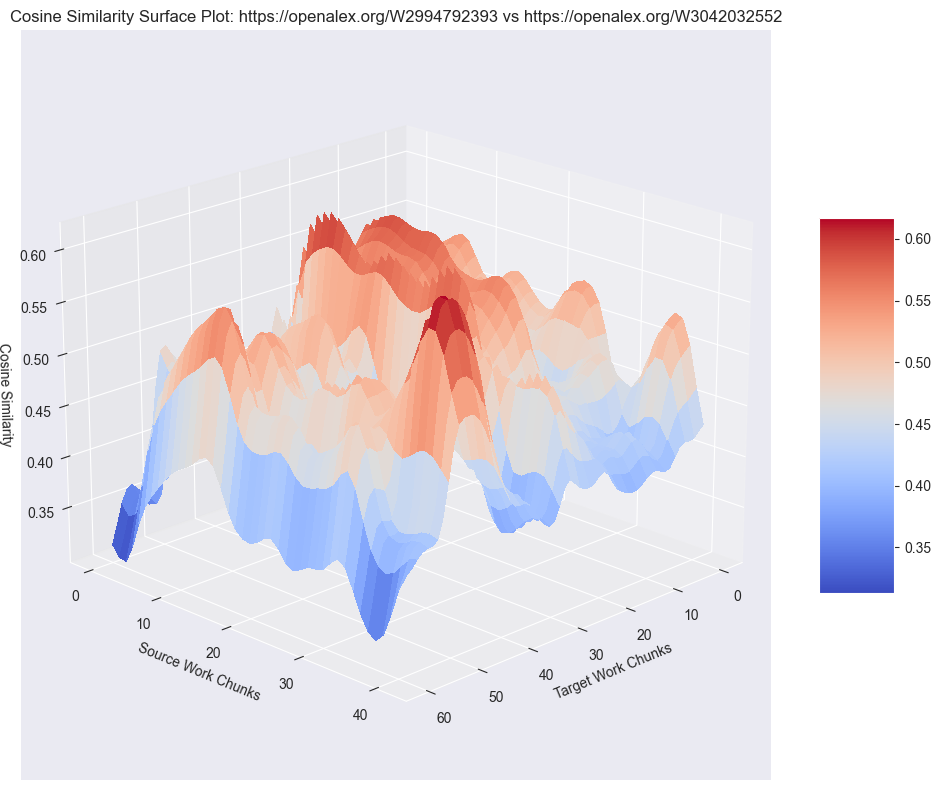

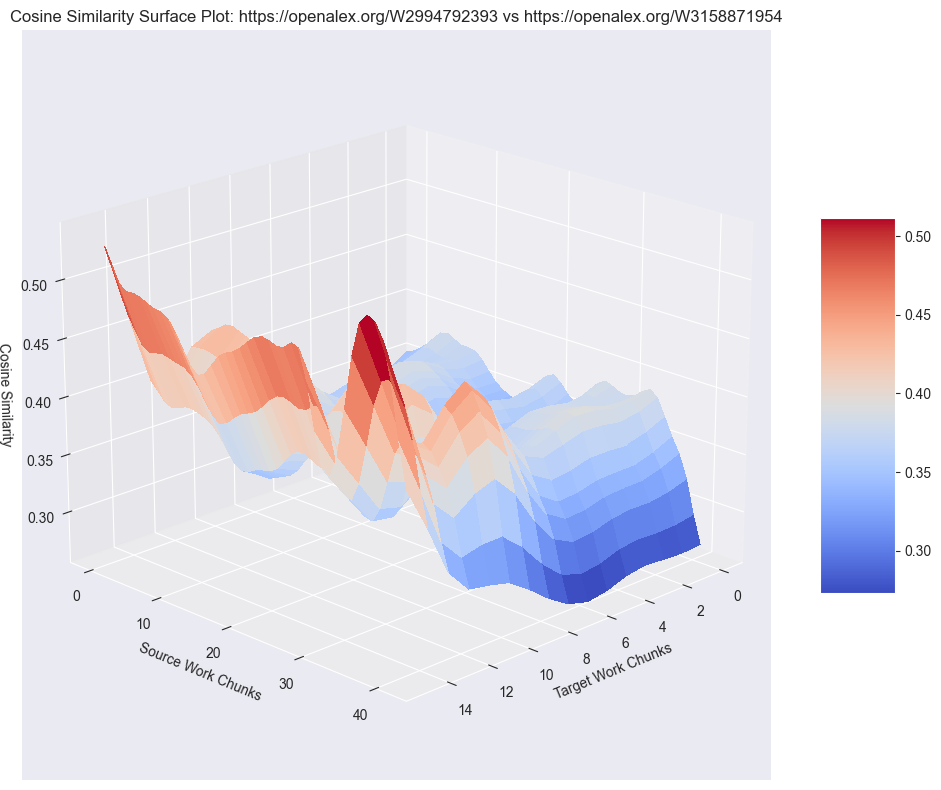

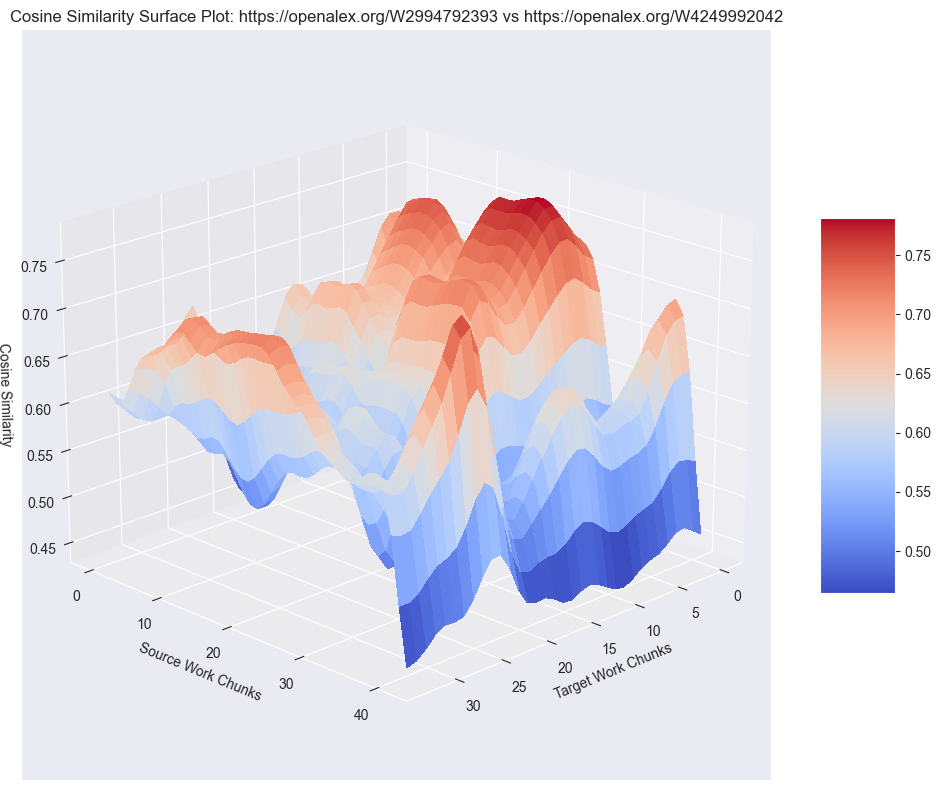

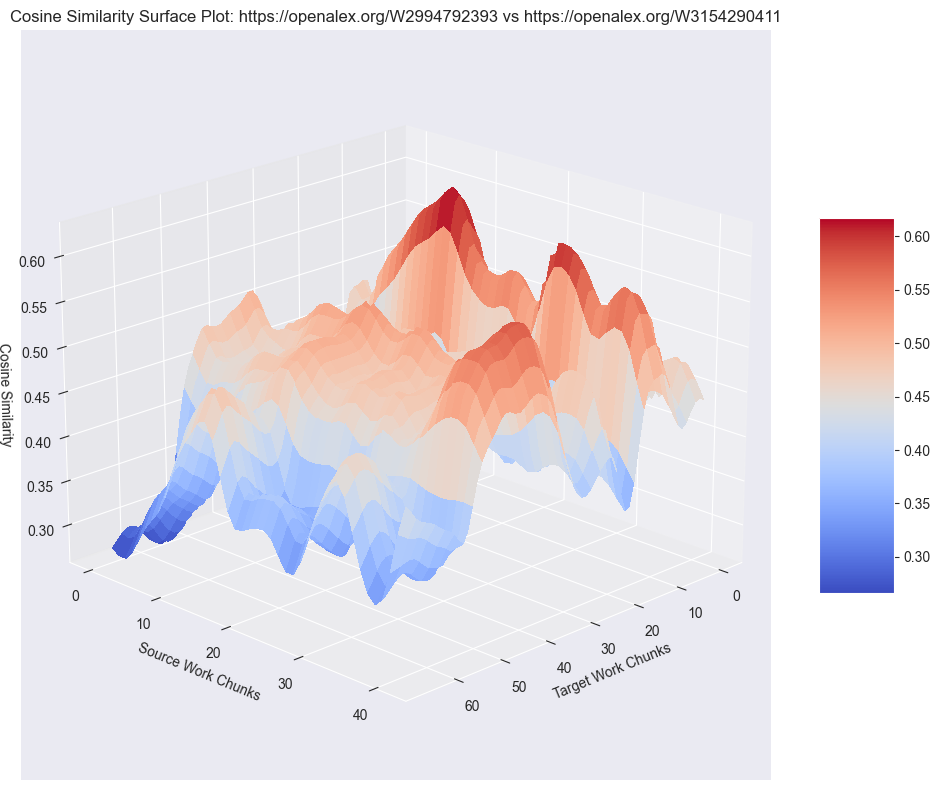

In [36]:
for work_id in CITATIONS:
    work_1 = FOCUS_PAPER
    work_2 = work_id

    plot_similarity_surface(work_1, work_2, sigma=1.5)